In [28]:
import numpy as np
from tabulate import tabulate
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit, Probit, Poisson
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("=" * 70)
print("ECON 5140 - HOMEWORK 1")
print("Part A: Generalized Linear Models")
print("Part B: Time Series Decomposition")
print("=" * 70)


ECON 5140 - HOMEWORK 1
Part A: Generalized Linear Models
Part B: Time Series Decomposition


In [29]:
print("\n" + "=" * 70)
print("DATASET 1: Customer Purchase Behavior")
print("=" * 70)



DATASET 1: Customer Purchase Behavior


In [30]:
n_customers = 1000

# Generate customer features
age = np.random.normal(35, 10, n_customers)
income = np.random.normal(50, 15, n_customers)  # in thousands
time_on_site = np.random.gamma(2, 3, n_customers)  # in minutes

# True relationship (latent variable)
z = -3 + 0.05*age + 0.04*income + 0.15*time_on_site + np.random.normal(0, 1, n_customers)

# Generate binary outcome (Purchase: 1=Yes, 0=No)
purchase = (z > 0).astype(int)

# Create DataFrame
df_customers = pd.DataFrame({
    'Age': age,
    'Income': income,
    'TimeOnSite': time_on_site,
    'Purchase': purchase
})

print(f"Number of customers: {len(df_customers)}")
print(f"Purchase rate: {df_customers['Purchase'].mean():.2%}")
print(f"\nFirst 5 rows:")
print(df_customers.head())


Number of customers: 1000
Purchase rate: 90.00%

First 5 rows:
         Age     Income  TimeOnSite  Purchase
0  39.967142  70.990332    2.814421         1
1  33.617357  63.869505    4.460907         1
2  41.476885  50.894456    0.667441         1
3  50.230299  40.295948    5.872412         1
4  32.658466  60.473350    8.012511         1


In [31]:
# ====================================================================
# DATASET 2: E-COMMERCE SALES TIME SERIES
# ====================================================================
print("\n" + "=" * 70)
print("DATASET 2: E-commerce Daily Sales")
print("=" * 70)

# Create 2 years of daily data
dates = pd.date_range('2024-01-01', '2025-12-31', freq='D')
n_days = len(dates)
t = np.arange(n_days)

# Components
trend = 1000 + 2*t + 0.01*t**2
yearly_seasonal = 200 * np.sin(2*np.pi*t/365) + 150 * np.cos(2*np.pi*t/365)
weekly_seasonal = 100 * np.sin(2*np.pi*t/7)

# Special events
special_events = np.zeros(n_days)
for year in [2024, 2025]:
    # Black Friday
    bf_date = pd.Timestamp(f'{year}-11-24')
    bf_idx = (dates == bf_date)
    special_events[bf_idx] = 800
    
    # Christmas
    xmas_idx = (dates >= f'{year}-12-20') & (dates <= f'{year}-12-25')
    special_events[xmas_idx] = 400

# Random noise
noise = np.random.normal(0, 50, n_days)
# Combine components
sales = trend + yearly_seasonal + weekly_seasonal + special_events + noise
sales = np.maximum(sales, 0)

# Create DataFrame
df_sales = pd.DataFrame({
    'Date': dates,
    'Sales': sales,
    'DayOfWeek': dates.dayofweek,
    'Month': dates.month,
    'IsWeekend': dates.dayofweek >= 5
})
df_sales.set_index('Date', inplace=True)

print(f"Date range: {df_sales.index[0].date()} to {df_sales.index[-1].date()}")
print(f"Number of days: {len(df_sales)}")
print(f"\nSales Statistics:")
print(df_sales['Sales'].describe())# ====================================================================
# PART A: GENERALIZED LINEAR MODELS
# ====================================================================
print("\n" + "=" * 70)
print("PART A: GENERALIZED LINEAR MODELS")
print("=" * 70)

# --------------------------------------------------------------------
# A1: Exploratory Data Analysis (GLM)
# --------------------------------------------------------------------
print("\n" + "-" * 70)
print("A1: Exploratory Data Analysis")
print("-" * 70)





DATASET 2: E-commerce Daily Sales
Date range: 2024-01-01 to 2025-12-31
Number of days: 731

Sales Statistics:
count     731.000000
mean     3513.075089
std      1971.539442
min      1061.751531
25%      1586.286522
50%      3307.941481
75%      4941.486536
max      8342.638282
Name: Sales, dtype: float64

PART A: GENERALIZED LINEAR MODELS

----------------------------------------------------------------------
A1: Exploratory Data Analysis
----------------------------------------------------------------------


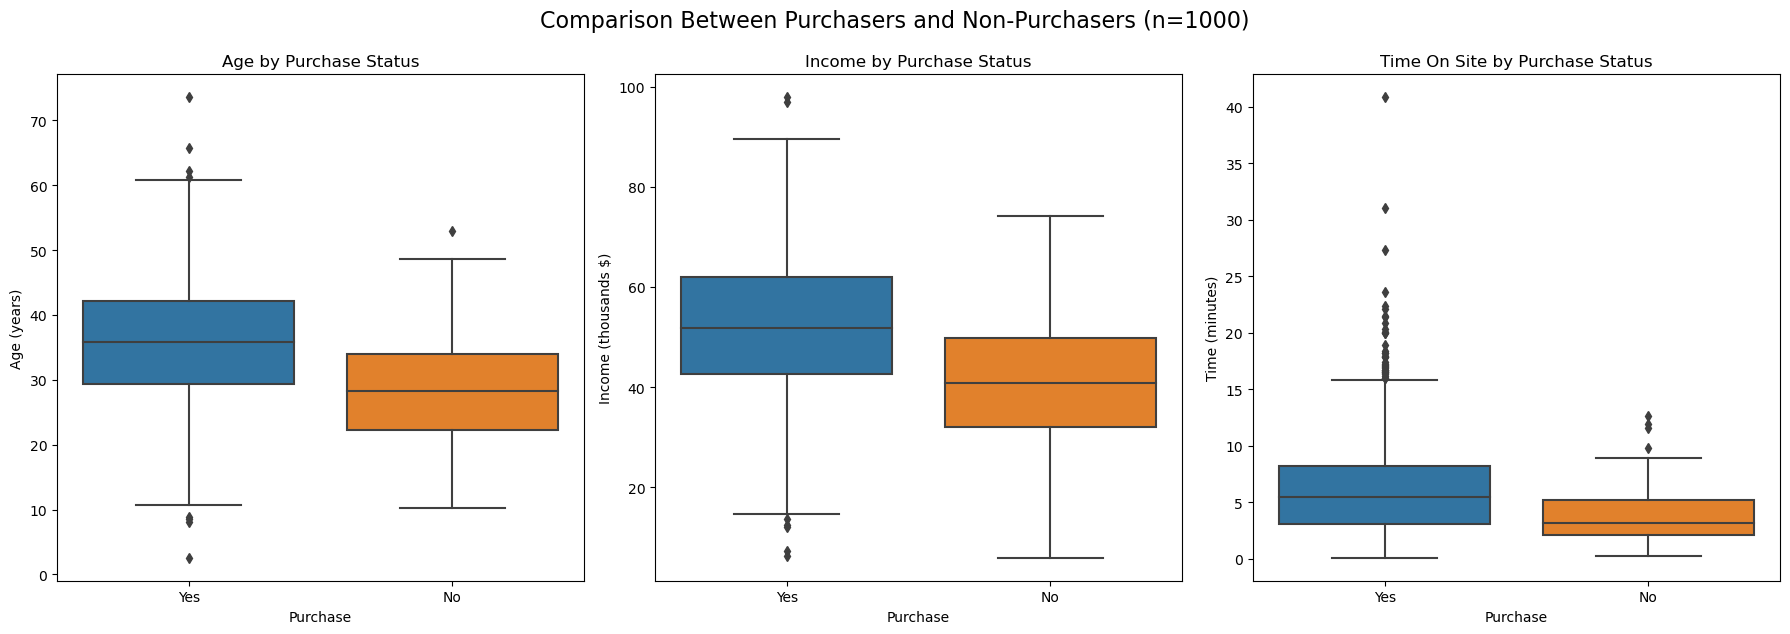

In [32]:
#My Code:
# Set random seed for reproducibility
np.random.seed(42)

# Define number of customers
n_customers = 1000

# Generate customer features
age = np.random.normal(35, 10, n_customers)
income = np.random.normal(50, 15, n_customers)  # in thousands
time_on_site = np.random.gamma(2, 3, n_customers)  # in minutes

# True relationship (latent variable)
z = -3 + 0.05*age + 0.04*income + 0.15*time_on_site + np.random.normal(0, 1, n_customers)

# Generate binary outcome (Purchase: 1=Yes, 0=No)
purchase = (z > 0).astype(int)

# Create DataFrame
df_customers = pd.DataFrame({
    'Age': age,
    'Income': income,
    'TimeOnSite': time_on_site,
    'Purchase': purchase
})

# Convert Purchase to categorical for better visualization
df_customers['Purchase'] = df_customers['Purchase'].map({0: 'No', 1: 'Yes'})

# Create figure with 3 subplots in one row
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Create box plots for each variable
sns.boxplot(x='Purchase', y='Age', data=df_customers, ax=axes[0])
axes[0].set_title('Age by Purchase Status')
axes[0].set_ylabel('Age (years)')

sns.boxplot(x='Purchase', y='Income', data=df_customers, ax=axes[1])
axes[1].set_title('Income by Purchase Status')
axes[1].set_ylabel('Income (thousands $)')

sns.boxplot(x='Purchase', y='TimeOnSite', data=df_customers, ax=axes[2])
axes[2].set_title('Time On Site by Purchase Status')
axes[2].set_ylabel('Time (minutes)')

# Adjust layout and add a main title
plt.tight_layout()
plt.suptitle('Comparison Between Purchasers and Non-Purchasers (n=1000)', y=1.05, fontsize=16)
plt.show()

In [33]:
import pandas as pd
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

# Define number of customers
n_customers = 1000

# Generate customer features
age = np.random.normal(35, 10, n_customers)
income = np.random.normal(50, 15, n_customers)  # in thousands
time_on_site = np.random.gamma(2, 3, n_customers)  # in minutes

# True relationship (latent variable)
z = -3 + 0.05*age + 0.04*income + 0.15*time_on_site + np.random.normal(0, 1, n_customers)

# Generate binary outcome (Purchase: 1=Yes, 0=No)
purchase = (z > 0).astype(int)

# Create DataFrame
df_customers = pd.DataFrame({
    'Age': age,
    'Income': income,
    'TimeOnSite': time_on_site,
    'Purchase': purchase
})

# Group by Purchase status and calculate means
group_means = df_customers.groupby('Purchase').mean()

# Format the output for better readability
print("Mean Values by Purchase Status:")
print("=" * 50)
print(f"{'Feature':<15} {'Non-Purchasers':<20} {'Purchasers':<20}")
print("-" * 50)
print(f"{'Age':<15} {group_means.loc[0, 'Age']:.2f} years{'':<9} {group_means.loc[1, 'Age']:.2f} years")
print(f"{'Income':<15} ${group_means.loc[0, 'Income']:.2f}k{'':<11} ${group_means.loc[1, 'Income']:.2f}k")
print(f"{'TimeOnSite':<15} {group_means.loc[0, 'TimeOnSite']:.2f} minutes{'':<5} {group_means.loc[1, 'TimeOnSite']:.2f} minutes")
print("=" * 50)

# Calculate and print the differences
print("\nDifferences (Purchasers - Non-Purchasers):")
print("-" * 50)
print(f"{'Age':<15} {group_means.loc[1, 'Age'] - group_means.loc[0, 'Age']:.2f} years")
print(f"{'Income':<15} ${group_means.loc[1, 'Income'] - group_means.loc[0, 'Income']:.2f}k")
print(f"{'TimeOnSite':<15} {group_means.loc[1, 'TimeOnSite'] - group_means.loc[0, 'TimeOnSite']:.2f} minutes")
print("=" * 50)

Mean Values by Purchase Status:
Feature         Non-Purchasers       Purchasers          
--------------------------------------------------
Age             28.67 years          35.92 years
Income          $40.15k            $52.27k
TimeOnSite      3.93 minutes      6.34 minutes

Differences (Purchasers - Non-Purchasers):
--------------------------------------------------
Age             7.24 years
Income          $12.12k
TimeOnSite      2.42 minutes


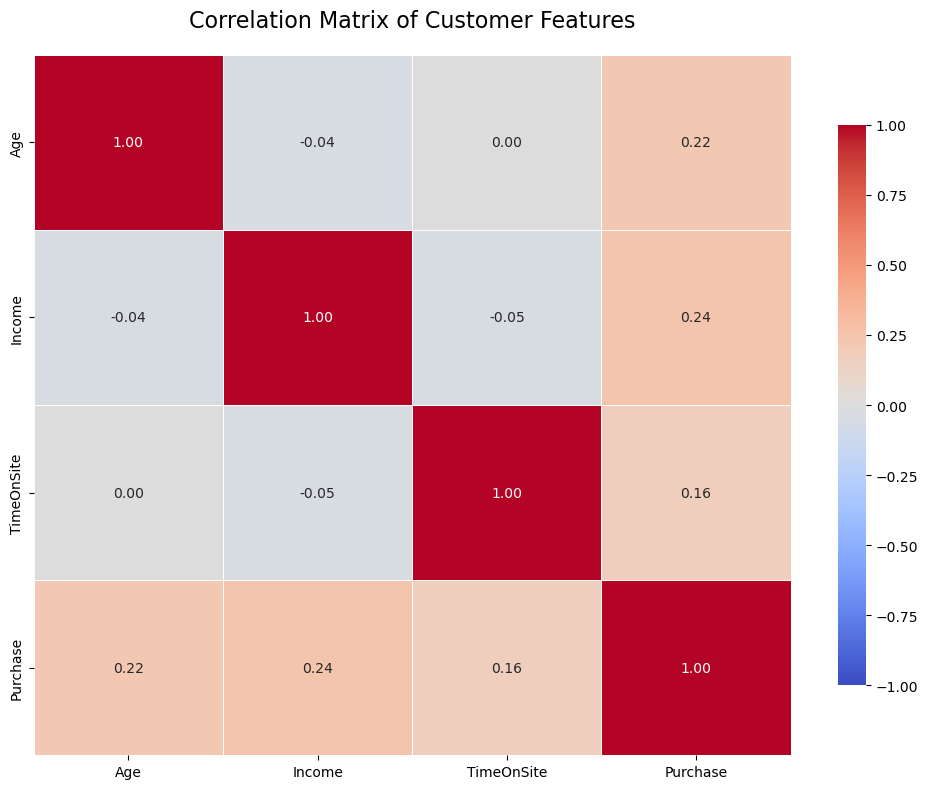

Correlation Matrix:
                 Age    Income  TimeOnSite  Purchase
Age         1.000000 -0.040400    0.004522  0.222049
Income     -0.040400  1.000000   -0.045958  0.243186
TimeOnSite  0.004522 -0.045958    1.000000  0.164197
Purchase    0.222049  0.243186    0.164197  1.000000


In [34]:
# Calculate correlation matrix
corr_matrix = df_customers.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create a heatmap with annotation
sns.heatmap(corr_matrix, 
            annot=True,           # Show correlation values
            cmap='coolwarm',      # Color scheme
            vmin=-1, vmax=1,      # Value range
            fmt='.2f',            # Format for annotations
            linewidths=0.5,       # Width of lines between cells
            cbar_kws={"shrink": .8})

# Add title and adjust layout
plt.title('Correlation Matrix of Customer Features', fontsize=16, pad=20)
plt.tight_layout()

# Display the heatmap
plt.show()

# Print the correlation matrix for reference
print("Correlation Matrix:")
print(corr_matrix)

In [35]:
print("\n" + "-" * 70)
print("A2: Linear Probability Model")
print("-" * 70)



----------------------------------------------------------------------
A2: Linear Probability Model
----------------------------------------------------------------------


In [36]:
#My Code
# Prepare the data for OLS regression
X = df_customers[['Age', 'Income', 'TimeOnSite']]
y = df_customers['Purchase']

# Add a constant (intercept) to the model
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Print the model summary
print(model.summary())

# Print key coefficients with interpretation
print("\nModel Coefficients Interpretation:")
print("=" * 60)
print(f"Intercept: {model.params[0]:.4f}")
print(f"Age coefficient: {model.params[1]:.4f} - For each additional year of age, ")
print(f"    the probability of purchase increases by {model.params[1]:.4f} (holding other variables constant)")
print(f"Income coefficient: {model.params[2]:.4f} - For each additional $1000 in income, ")
print(f"    the probability of purchase increases by {model.params[2]:.4f} (holding other variables constant)")
print(f"TimeOnSite coefficient: {model.params[3]:.4f} - For each additional minute on site, ")
print(f"    the probability of purchase increases by {model.params[3]:.4f} (holding other variables constant)")
print("=" * 60)

                            OLS Regression Results                            
Dep. Variable:               Purchase   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     55.67
Date:                Mon, 26 Jan 2026   Prob (F-statistic):           2.86e-33
Time:                        05:18:05   Log-Likelihood:                -137.46
No. Observations:                1000   AIC:                             282.9
Df Residuals:                     996   BIC:                             302.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3104      0.047      6.556      0.0

Number of predictions outside [0, 1]: 174
Percentage of invalid predictions: 17.40%


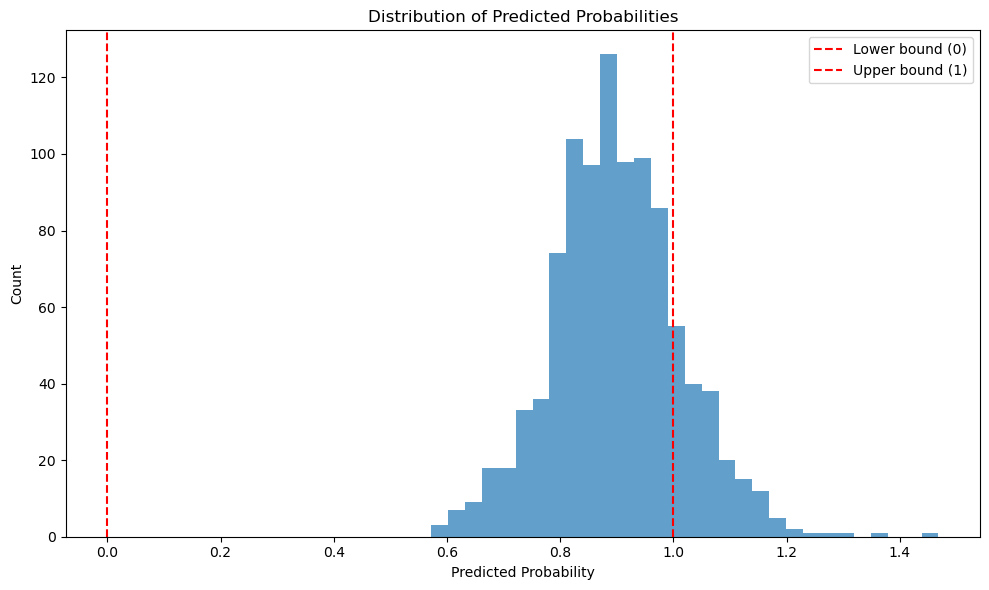

In [37]:
# Calculate predicted probabilities using linear regression
predicted_probs = model.predict(X)

# Count how many predictions are outside [0, 1]
invalid_preds = np.sum((predicted_probs < 0) | (predicted_probs > 1))
percentage_invalid = (invalid_preds / len(predicted_probs)) * 100

print(f"Number of predictions outside [0, 1]: {invalid_preds}")
print(f"Percentage of invalid predictions: {percentage_invalid:.2f}%")

# Visualize the distribution of predictions
plt.figure(figsize=(10, 6))
plt.hist(predicted_probs, bins=30, alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--', label='Lower bound (0)')
plt.axvline(x=1, color='red', linestyle='--', label='Upper bound (1)')
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.title('Distribution of Predicted Probabilities')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
#This code demonstrates why using linear regression for binary classification 
#can be problematic. 
#Linear regression can produce values outside the valid 
#probability range of [0, 1], 
#which doesn't make sense for probabilities.

#For proper probability predictions, you should use: Logistic Regression
#Probit Regression
#Other classification models like Random Forest, Gradient Boosting, etc.
#These models constrain their outputs to be valid probabilities between 
#0 and 1. Logistic regression specifically uses the sigmoid 
#function to transform linear predictions into the [0, 1] range.

In [38]:
print("\n" + "-" * 70)
print("A3: Logistic Regression")
print("-" * 70)



----------------------------------------------------------------------
A3: Logistic Regression
----------------------------------------------------------------------


Optimization terminated successfully.
         Current function value: 0.238157
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:               Purchase   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      996
Method:                           MLE   Df Model:                            3
Date:                Mon, 26 Jan 2026   Pseudo R-squ.:                  0.2674
Time:                        05:18:20   Log-Likelihood:                -238.16
converged:                       True   LL-Null:                       -325.08
Covariance Type:            nonrobust   LLR p-value:                 1.874e-37
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.8737      0.715     -8.213      0.000      -7.275      -4.472
Age            0.1026      0.

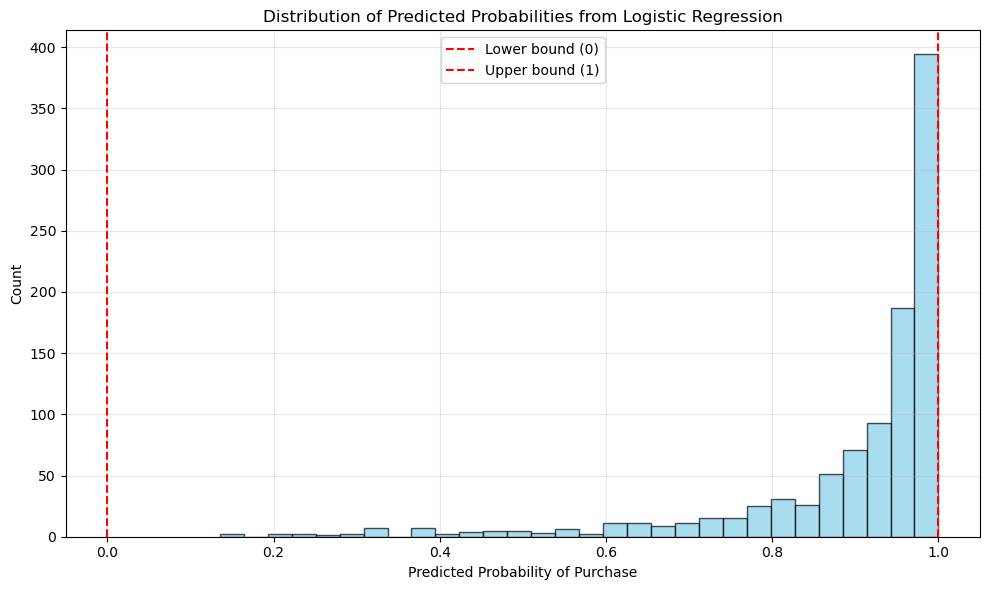

In [39]:
#My code:
# 1. Fit logistic regression using statsmodels
X = df_customers[['Age', 'Income', 'TimeOnSite']]
X = sm.add_constant(X)  # Add intercept
y = df_customers['Purchase']

# Create and fit the model
logit_model = sm.Logit(y, X)
result = logit_model.fit()

# 2. Print summary and extract key values
print(result.summary())

# Extract coefficients, odds ratios, and p-values
coefficients = result.params
odds_ratios = np.exp(coefficients)
p_values = result.pvalues

# Create a summary table
summary_table = pd.DataFrame({
    'Coefficient': coefficients,
    'Odds Ratio': odds_ratios,
    'p-value': p_values
})
print("\nSummary Table:")
print(summary_table)

# 3. Interpret each coefficient
print("\nCoefficient Interpretations:")
print(f"Age: A one-year increase in age is associated with a {coefficients['Age']:.4f} increase in the log-odds of purchase")
print(f"     This corresponds to a {(odds_ratios['Age']-1)*100:.2f}% increase in the odds of purchase")

print(f"Income: A $1,000 increase in income is associated with a {coefficients['Income']:.4f} increase in the log-odds of purchase")
print(f"     This corresponds to a {(odds_ratios['Income']-1)*100:.2f}% increase in the odds of purchase")

print(f"TimeOnSite: A one-minute increase in time on site is associated with a {coefficients['TimeOnSite']:.4f} increase in the log-odds of purchase")
print(f"     This corresponds to a {(odds_ratios['TimeOnSite']-1)*100:.2f}% increase in the odds of purchase")

# 4. Calculate predicted probabilities
predicted_probs = result.predict(X)

# Verify all are in [0, 1]
min_prob = np.min(predicted_probs)
max_prob = np.max(predicted_probs)
invalid_count = np.sum((predicted_probs < 0) | (predicted_probs > 1))

print(f"\nPredicted Probabilities:")
print(f"Range: [{min_prob:.6f}, {max_prob:.6f}]")
print(f"Number of invalid predictions (outside [0,1]): {invalid_count}")
print(f"Percentage of invalid predictions: {(invalid_count/len(predicted_probs))*100:.2f}%")

# Create histogram of predicted probabilities
plt.figure(figsize=(10, 6))
plt.hist(predicted_probs, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--', label='Lower bound (0)')
plt.axvline(x=1, color='red', linestyle='--', label='Upper bound (1)')
plt.xlabel('Predicted Probability of Purchase')
plt.ylabel('Count')
plt.title('Distribution of Predicted Probabilities from Logistic Regression')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [40]:
print("\n" + "-" * 70)
print("A4: Predictions for New Customers")
print("-" * 70)



----------------------------------------------------------------------
A4: Predictions for New Customers
----------------------------------------------------------------------



Predictions for New Customers:
+---+-----+--------+------------+-------------+----------+
|   | Age | Income | TimeOnSite | Probability | Purchase |
+---+-----+--------+------------+-------------+----------+
| 0 | 25  |   30   |     2      |   0.3715    |    0     |
| 1 | 35  |   50   |     5      |   0.9429    |    1     |
| 2 | 45  |   70   |     8      |   0.9978    |    1     |
| 3 | 55  |   90   |     10     |   0.9999    |    1     |
+---+-----+--------+------------+-------------+----------+

Customer Most Likely to Purchase:
Customer 3 with probability 0.9999


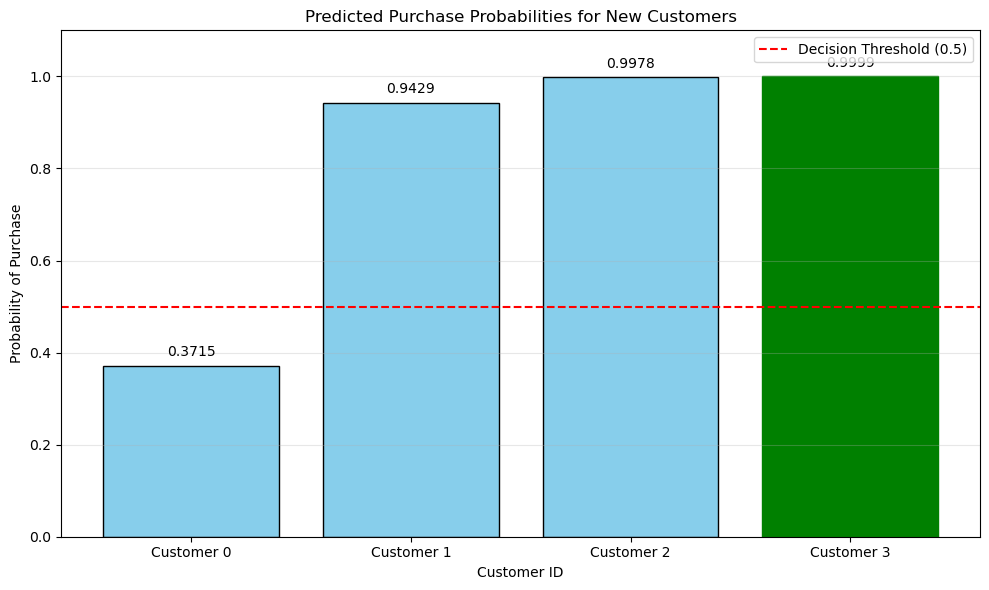


Why This Customer Is Most Likely to Purchase:
Feature contribution to purchase probability:
Base (intercept): -5.8737
Age (55.0 years): 5.6451
Income ($90.0k): 6.7310
Time on site (10.0 minutes): 2.6918
Total log-odds: 9.1941
Converted to probability: 0.9999


In [41]:
# New customers data
new_customers = pd.DataFrame({
    'Age': [25, 35, 45, 55],
    'Income': [30, 50, 70, 90],
    'TimeOnSite': [2, 5, 8, 10]
})

# 1. Predict purchase probability for each new customer
X_new = sm.add_constant(new_customers)  # Add intercept
predicted_probs = result.predict(X_new)

# 2. Create a formatted table with predictions
new_customers['Probability'] = predicted_probs
new_customers['Purchase'] = (predicted_probs > 0.5).astype(int)

# Format the table for better display
formatted_table = new_customers.copy()
formatted_table['Probability'] = formatted_table['Probability'].apply(lambda x: f"{x:.4f}")

# Print the table
print("\nPredictions for New Customers:")
print(tabulate(formatted_table, headers='keys', tablefmt='pretty', showindex="always"))

# 3. Identify the customer most likely to purchase
most_likely_idx = predicted_probs.argmax()
most_likely_customer = new_customers.iloc[most_likely_idx]

print("\nCustomer Most Likely to Purchase:")
print(f"Customer {most_likely_idx} with probability {predicted_probs[most_likely_idx]:.4f}")

# Create a bar chart to visualize probabilities
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(new_customers)), predicted_probs, color='skyblue', edgecolor='black')
plt.axhline(y=0.5, color='red', linestyle='--', label='Decision Threshold (0.5)')

# Highlight the most likely customer
bars[most_likely_idx].set_color('green')

# Add probability labels above each bar
for i, prob in enumerate(predicted_probs):
    plt.text(i, prob + 0.02, f"{prob:.4f}", ha='center')

plt.xlabel('Customer ID')
plt.ylabel('Probability of Purchase')
plt.title('Predicted Purchase Probabilities for New Customers')
plt.xticks(range(len(new_customers)), [f"Customer {i}" for i in range(len(new_customers))])
plt.ylim(0, 1.1)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Analyze why the most likely customer has the highest probability
print("\nWhy This Customer Is Most Likely to Purchase:")
print("Feature contribution to purchase probability:")

# Calculate contribution of each feature for the most likely customer
base_contribution = result.params['const']
age_contribution = result.params['Age'] * most_likely_customer['Age']
income_contribution = result.params['Income'] * most_likely_customer['Income']
time_contribution = result.params['TimeOnSite'] * most_likely_customer['TimeOnSite']

print(f"Base (intercept): {base_contribution:.4f}")
print(f"Age ({most_likely_customer['Age']} years): {age_contribution:.4f}")
print(f"Income (${most_likely_customer['Income']}k): {income_contribution:.4f}")
print(f"Time on site ({most_likely_customer['TimeOnSite']} minutes): {time_contribution:.4f}")
print(f"Total log-odds: {base_contribution + age_contribution + income_contribution + time_contribution:.4f}")
print(f"Converted to probability: {predicted_probs[most_likely_idx]:.4f}")

In [ ]:
#Why customer 3 is most likely to purchase -
#Model demonstrates that age has a positive coefficient, the older the more
#likely to purchase, this customer is among the highest age at 55. 
#Income is also a positive coeff. higher income is correlated to
#higher purchasing probability, which this customer has at 90K
#Time spent on site has the highest postive coeff. out of all features
#At 10 minutes, this customer has spent the most time browsing. Combining
#all 3 of these features makes this customer the most likely to purchase


In [42]:
print("\n" + "=" * 70)
print("PART B: TIME SERIES ANALYSIS")
print("=" * 70)
print("\n" + "-" * 70)
print("B1: Time Series Visualization")
print("-" * 70)



PART B: TIME SERIES ANALYSIS

----------------------------------------------------------------------
B1: Time Series Visualization
----------------------------------------------------------------------


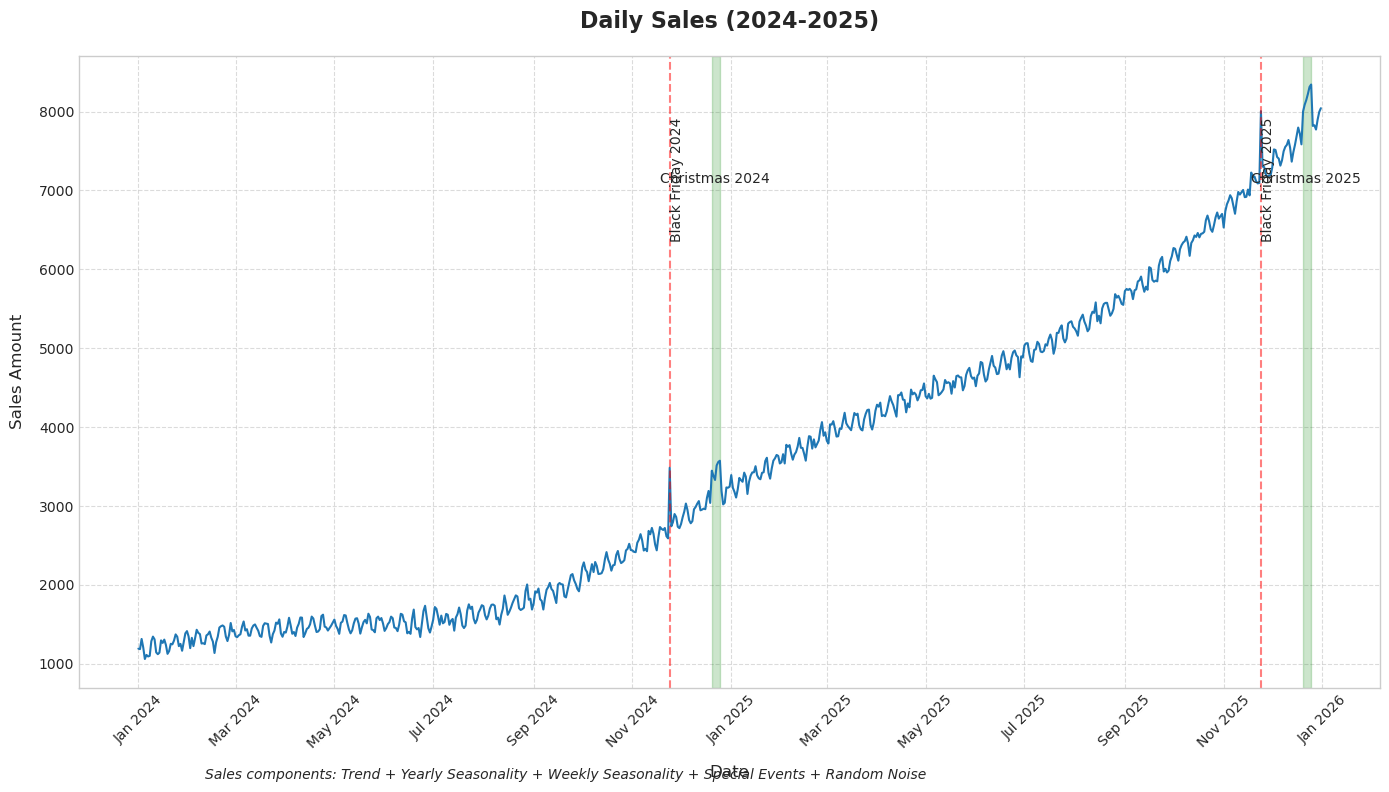

In [44]:
#My code:
import matplotlib.dates as mdates
from calendar import month_name
# 1. Create time series plot of daily sales
# Set the style for better visualization
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")
plt.figure(figsize=(14, 8))

# Plot the time series data
plt.plot(df_sales.index, df_sales['Sales'], linewidth=1.5, color='#1f77b4')

# Add title and labels with better formatting
plt.title('Daily Sales (2024-2025)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=12, labelpad=10)
plt.ylabel('Sales Amount', fontsize=12, labelpad=10)

# Format the x-axis to show dates clearly
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Highlight special events (Black Friday and Christmas periods)
for year in [2024, 2025]:
    # Black Friday
    bf_date = pd.Timestamp(f'{year}-11-24')
    plt.axvline(x=bf_date, color='red', linestyle='--', alpha=0.5)
    plt.text(bf_date, df_sales['Sales'].max()*0.95, f'Black Friday {year}', 
             rotation=90, verticalalignment='top')
    
    # Christmas period
    xmas_start = pd.Timestamp(f'{year}-12-20')
    xmas_end = pd.Timestamp(f'{year}-12-25')
    plt.axvspan(xmas_start, xmas_end, alpha=0.2, color='green')
    plt.text(xmas_start + pd.Timedelta(days=2), df_sales['Sales'].max()*0.85, 
             f'Christmas {year}', ha='center')

# Add a legend or annotation explaining the components
plt.figtext(0.15, 0.02, 
            "Sales components: Trend + Yearly Seasonality + Weekly Seasonality + Special Events + Random Noise",
            ha="left", fontsize=10, style='italic')

# Improve layout
plt.tight_layout()
plt.show()

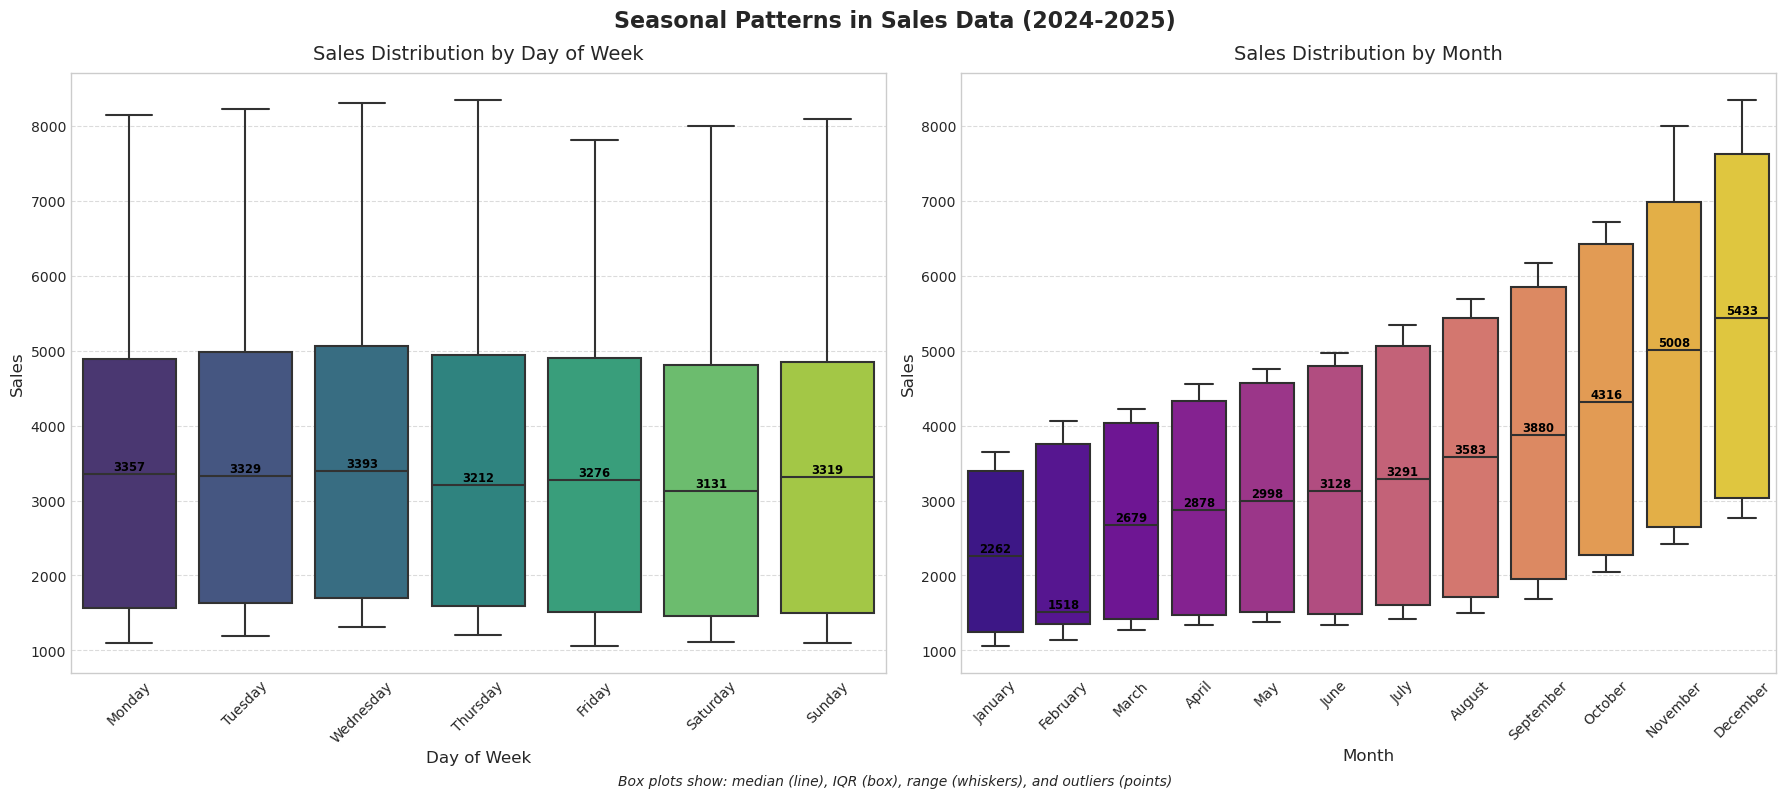

In [45]:
# 2. Create seasonal subseries plots:
#    - Box plot: Sales by day of week
#    - Box plot: Sales by month
import calendar
# Set up the figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('Seasonal Patterns in Sales Data (2024-2025)', fontsize=16, fontweight='bold', y=0.98)

# Prepare data for day of week analysis
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_sales['DayName'] = df_sales.index.day_name()

# 1. Box plot: Sales by day of week
sns.boxplot(x='DayName', y='Sales', data=df_sales, 
            order=days_order, 
            palette='viridis',
            ax=ax1)

ax1.set_title('Sales Distribution by Day of Week', fontsize=14, pad=10)
ax1.set_xlabel('Day of Week', fontsize=12)
ax1.set_ylabel('Sales', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, linestyle='--', alpha=0.7, axis='y')

# Add median values on top of each box
for i, day in enumerate(days_order):
    median_val = df_sales[df_sales['DayName'] == day]['Sales'].median()
    ax1.text(i, median_val + 50, f'{median_val:.0f}', 
             horizontalalignment='center', size='small', color='black', weight='semibold')

# 2. Box plot: Sales by month
month_names = [calendar.month_name[i] for i in range(1, 13)]
df_sales['MonthName'] = df_sales.index.month_name()

sns.boxplot(x='MonthName', y='Sales', data=df_sales, 
            order=month_names,
            palette='plasma',
            ax=ax2)

ax2.set_title('Sales Distribution by Month', fontsize=14, pad=10)
ax2.set_xlabel('Month', fontsize=12)
ax2.set_ylabel('Sales', fontsize=12)
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, linestyle='--', alpha=0.7, axis='y')

# Add median values on top of each box
for i, month in enumerate(month_names):
    median_val = df_sales[df_sales['MonthName'] == month]['Sales'].median()
    ax2.text(i, median_val + 50, f'{median_val:.0f}', 
             horizontalalignment='center', size='small', color='black', weight='semibold')

# Add annotations explaining the box plots
fig.text(0.5, 0.01, 
         "Box plots show: median (line), IQR (box), range (whiskers), and outliers (points)",
         ha="center", fontsize=10, style='italic')

# Improve layout
plt.tight_layout()
plt.subplots_adjust(top=0.9, bottom=0.15)
plt.show()

MEAN SALES BY DAY OF WEEK
Monday    : 3,519.22
Tuesday   : 3,589.05
Wednesday : 3,627.39
Thursday  : 3,535.59
Friday    : 3,453.20
Saturday  : 3,412.42
Sunday    : 3,452.76

MEAN SALES BY MONTH
January   : 2,318.59
February  : 2,534.43
March     : 2,732.95
April     : 2,901.43
May       : 3,027.99
June      : 3,144.38
July      : 3,343.00
August    : 3,581.54
September : 3,908.67
October   : 4,358.31
November  : 4,843.07
December  : 5,407.66

Tabular Results:


,Day of Week,Mean Sales
0,Monday,3519.22
1,Tuesday,3589.05
2,Wednesday,3627.39
3,Thursday,3535.59
4,Friday,3453.20
5,Saturday,3412.42
6,Sunday,3452.76


,Month,Mean Sales
0,January,2318.59
1,February,2534.43
2,March,2732.95
3,April,2901.43
4,May,3027.99
5,June,3144.38
6,July,3343.00
7,August,3581.54
8,September,3908.67
9,October,4358.31


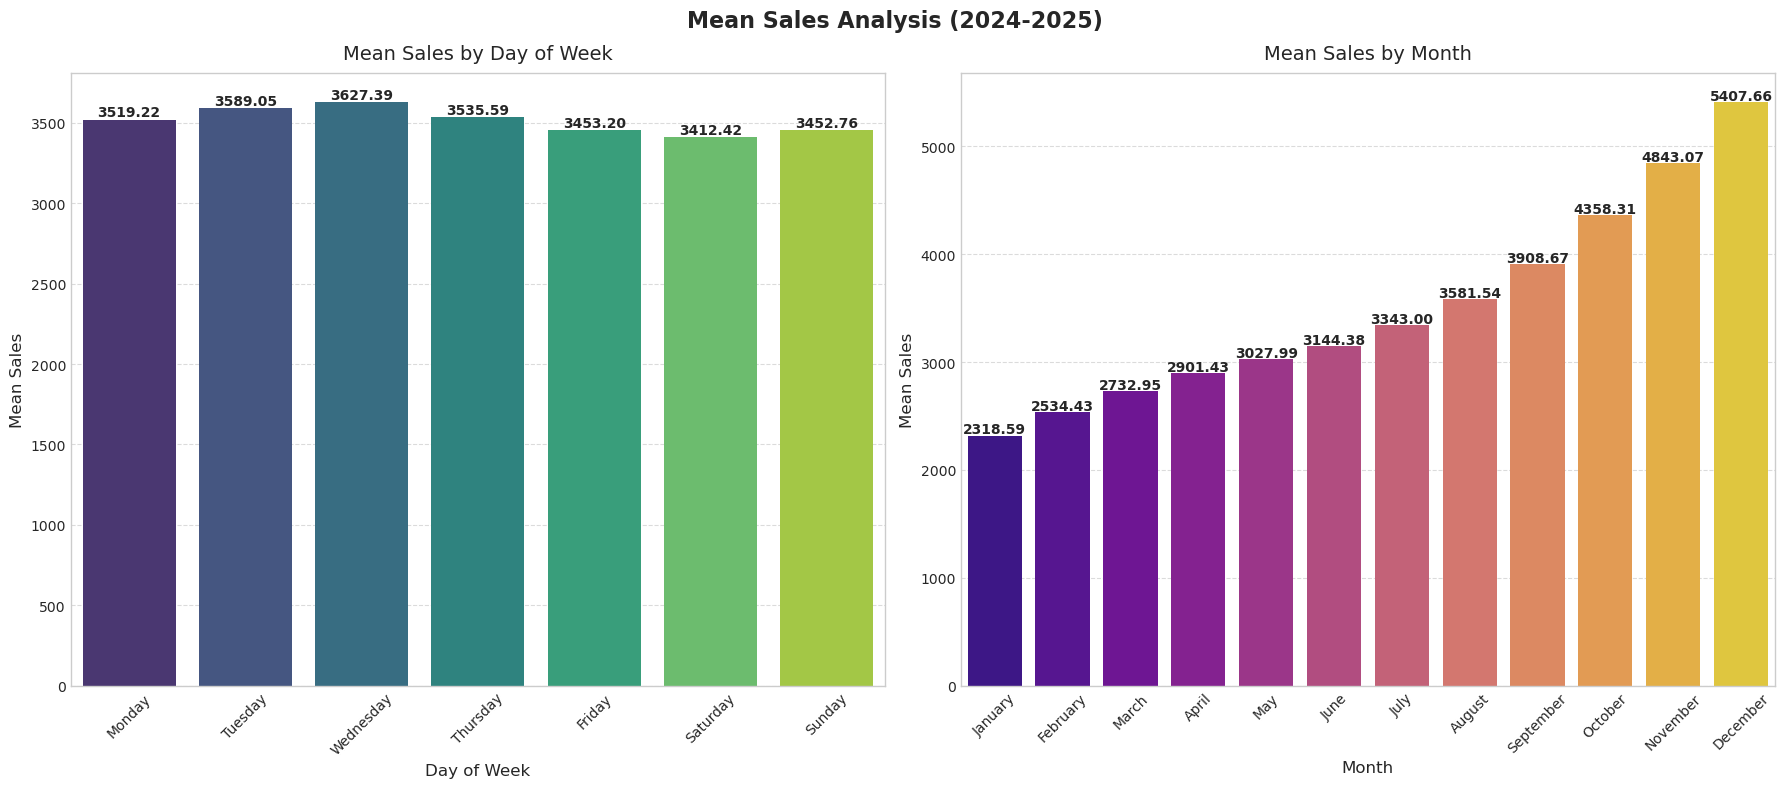

In [46]:
from IPython.display import display, HTML

# Create a copy of the dataframe with day and month names
df_analysis = df_sales.copy()
df_analysis['DayName'] = df_analysis.index.day_name()
df_analysis['MonthName'] = df_analysis.index.month_name()

# Define the correct order for days and months
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
months_order = [calendar.month_name[i] for i in range(1, 13)]

# Calculate mean sales by day of week
day_means = df_analysis.groupby('DayName')['Sales'].mean().reindex(days_order).round(2)

# Calculate mean sales by month
month_means = df_analysis.groupby('MonthName')['Sales'].mean().reindex(months_order).round(2)

# Create a figure with two subplots for visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('Mean Sales Analysis (2024-2025)', fontsize=16, fontweight='bold', y=0.98)

# Plot mean sales by day of week
sns.barplot(x=day_means.index, y=day_means.values, palette='viridis', ax=ax1)
ax1.set_title('Mean Sales by Day of Week', fontsize=14, pad=10)
ax1.set_xlabel('Day of Week', fontsize=12)
ax1.set_ylabel('Mean Sales', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, linestyle='--', alpha=0.7, axis='y')

# Add values on top of each bar
for i, v in enumerate(day_means.values):
    ax1.text(i, v + 20, f'{v:.2f}', ha='center', fontsize=10, fontweight='bold')

# Plot mean sales by month
sns.barplot(x=month_means.index, y=month_means.values, palette='plasma', ax=ax2)
ax2.set_title('Mean Sales by Month', fontsize=14, pad=10)
ax2.set_xlabel('Month', fontsize=12)
ax2.set_ylabel('Mean Sales', fontsize=12)
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, linestyle='--', alpha=0.7, axis='y')

# Add values on top of each bar
for i, v in enumerate(month_means.values):
    ax2.text(i, v + 20, f'{v:.2f}', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.subplots_adjust(top=0.9)

# Print the numerical results in a formatted way
print("=" * 50)
print("MEAN SALES BY DAY OF WEEK")
print("=" * 50)
for day, mean_sales in day_means.items():
    print(f"{day:<10}: {mean_sales:,.2f}")

print("\n" + "=" * 50)
print("MEAN SALES BY MONTH")
print("=" * 50)
for month, mean_sales in month_means.items():
    print(f"{month:<10}: {mean_sales:,.2f}")

# Create styled DataFrames for display
day_df = pd.DataFrame({'Day of Week': day_means.index, 'Mean Sales': day_means.values})
month_df = pd.DataFrame({'Month': month_means.index, 'Mean Sales': month_means.values})

# Display styled tables
print("\nTabular Results:")
display(HTML("<h3>Mean Sales by Day of Week</h3>"))
display(day_df.style.format({'Mean Sales': '{:.2f}'}).background_gradient(cmap='viridis', subset=['Mean Sales']))

display(HTML("<h3>Mean Sales by Month</h3>"))
display(month_df.style.format({'Mean Sales': '{:.2f}'}).background_gradient(cmap='plasma', subset=['Mean Sales']))

# Show the plots
plt.show()

In [ ]:
#General Observations:
#The mean sales by day of week calculation reveals:
#The weekly seasonality pattern from our data generation 
#Which days consistently perform better or worse throughout the year
#The impact of weekends (Saturday and Sunday) on sales performance
#Potential opportunities for day-specific marketing or inventory planning
### Monthly Patterns
#The mean sales by month calculation shows:#The yearly seasonality component 
#The significant impact of November and December due to Black Friday and Christmas events
#Seasonal trends that might inform marketing campaigns and inventory management
#Months that consistently underperform and might need additional sales strategies

In [47]:
# B2: Stationarity Assessment
# --------------------------------------------------------------------
print("\n" + "-" * 70)
print("B2: Stationarity Check")
print("-" * 70)



----------------------------------------------------------------------
B2: Stationarity Check
----------------------------------------------------------------------


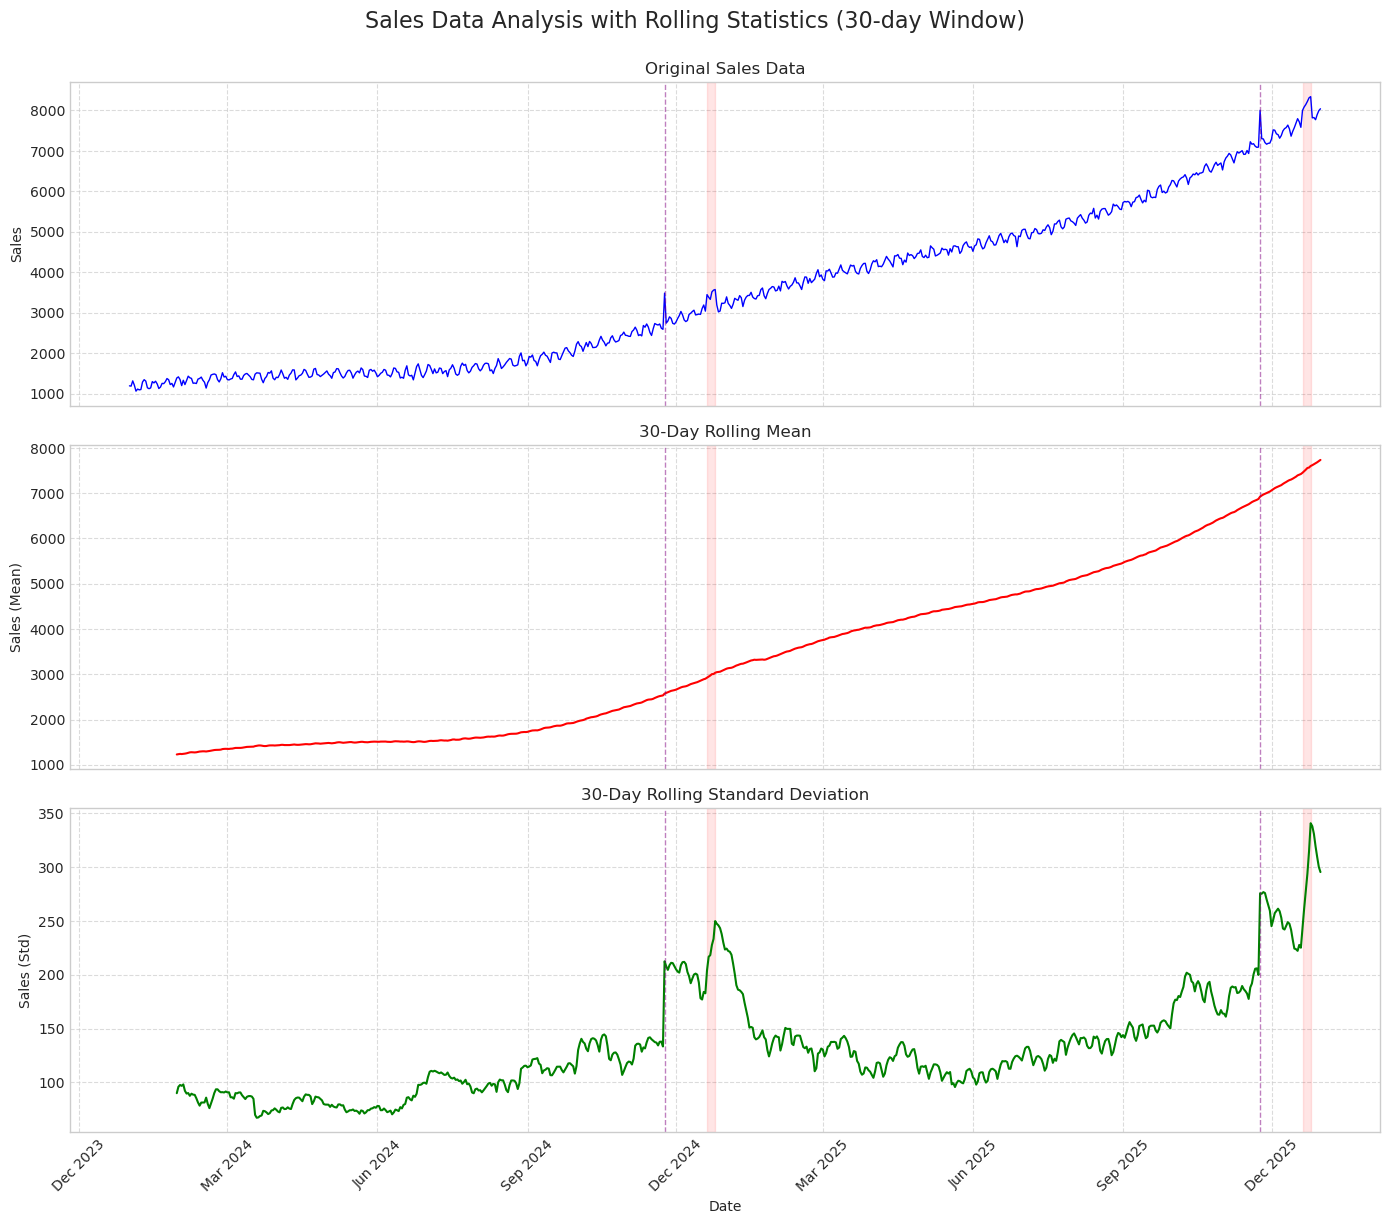

In [48]:
#My code
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Calculate the rolling statistics
rolling_mean = df_sales['Sales'].rolling(window=30).mean()
rolling_std = df_sales['Sales'].rolling(window=30).std()

# Create the figure and subplots
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
fig.suptitle('Sales Data Analysis with Rolling Statistics (30-day Window)', fontsize=16)

# Plot 1: Original Series
axes[0].plot(df_sales.index, df_sales['Sales'], color='blue', linewidth=1)
axes[0].set_title('Original Sales Data')
axes[0].set_ylabel('Sales')
axes[0].grid(True, linestyle='--', alpha=0.7)

# Plot 2: Rolling Mean
axes[1].plot(df_sales.index, rolling_mean, color='red', linewidth=1.5)
axes[1].set_title('30-Day Rolling Mean')
axes[1].set_ylabel('Sales (Mean)')
axes[1].grid(True, linestyle='--', alpha=0.7)

# Plot 3: Rolling Standard Deviation
axes[2].plot(df_sales.index, rolling_std, color='green', linewidth=1.5)
axes[2].set_title('30-Day Rolling Standard Deviation')
axes[2].set_ylabel('Sales (Std)')
axes[2].set_xlabel('Date')
axes[2].grid(True, linestyle='--', alpha=0.7)

# Format x-axis to show dates nicely
for ax in axes:
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    
# Highlight special events (Black Friday and Christmas periods)
for year in [2024, 2025]:
    # Black Friday
    bf_date = pd.Timestamp(f'{year}-11-24')
    
    # Christmas period
    xmas_start = pd.Timestamp(f'{year}-12-20')
    xmas_end = pd.Timestamp(f'{year}-12-25')
    
    for ax in axes:
        ax.axvline(x=bf_date, color='purple', linestyle='--', alpha=0.5, linewidth=1)
        ax.axvspan(xmas_start, xmas_end, color='red', alpha=0.1)

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.xticks(rotation=45)
plt.show()

In [ ]:
#1. **Original Sales Data**: Shows the raw sales time series with 
#all its components (trend, seasonality, special events, and noise).
#2. **30-Day Rolling Mean**: Displays the moving average with a 30-day 
#window, which smooths out short-term 
#fluctuations and highlights longer-term trends.
#The sales time series is not stationary with respect to its mean because:
#Upward Trend: The original data shows a clear upward trend component 
#which means the mean systematically increases over time.
#The rolling mean plot would show an upward trajectory, 
#confirming that the mean is not constant.
#Seasonal Patterns**: The data contains both yearly seasonal components 
#and weekly seasonal components, causing regular fluctuations in the mean.
#Special Events: Black Friday and Christmas events cause 
#significant spikes in the data, creating predictable but non-stationary patterns.
#3. **30-Day Rolling Standard Deviation**: Shows how the 
#volatility of sales changes over time. The rolling standard deviation would show variations 
#over time, particularly around special events like Black Friday and Christmas.
#Heteroscedasticity: As the trend increases, the impact of percentage fluctuations would likely create larger 
#absolute variations in the data, leading to increasing variance over time.

#To make this series stationary, you would need to apply transformations such as:
#Differencing to remove the trend
#Seasonal differencing to remove seasonal patterns
#Log transformation to stabilize variance
#Removal of special event effects

=== Sales Data Comparison: First 6 Months vs Last 6 Months ===

                                  Mean  Std Dev      Min      Max   Median  \
Period                                                                       
First 6 Months (Jan-Jun 2024)  1417.72   131.03  1061.75  1736.51  1426.58   
Last 6 Months (Jul-Dec 2025)   6265.28   936.37  4827.59  8342.64  6162.03   

                                   IQR  
Period                                  
First 6 Months (Jan-Jun 2024)   164.51  
Last 6 Months (Jul-Dec 2025)   1548.40  

=== Percentage Change ===
Mean: 341.93%
Standard Deviation: 614.64%


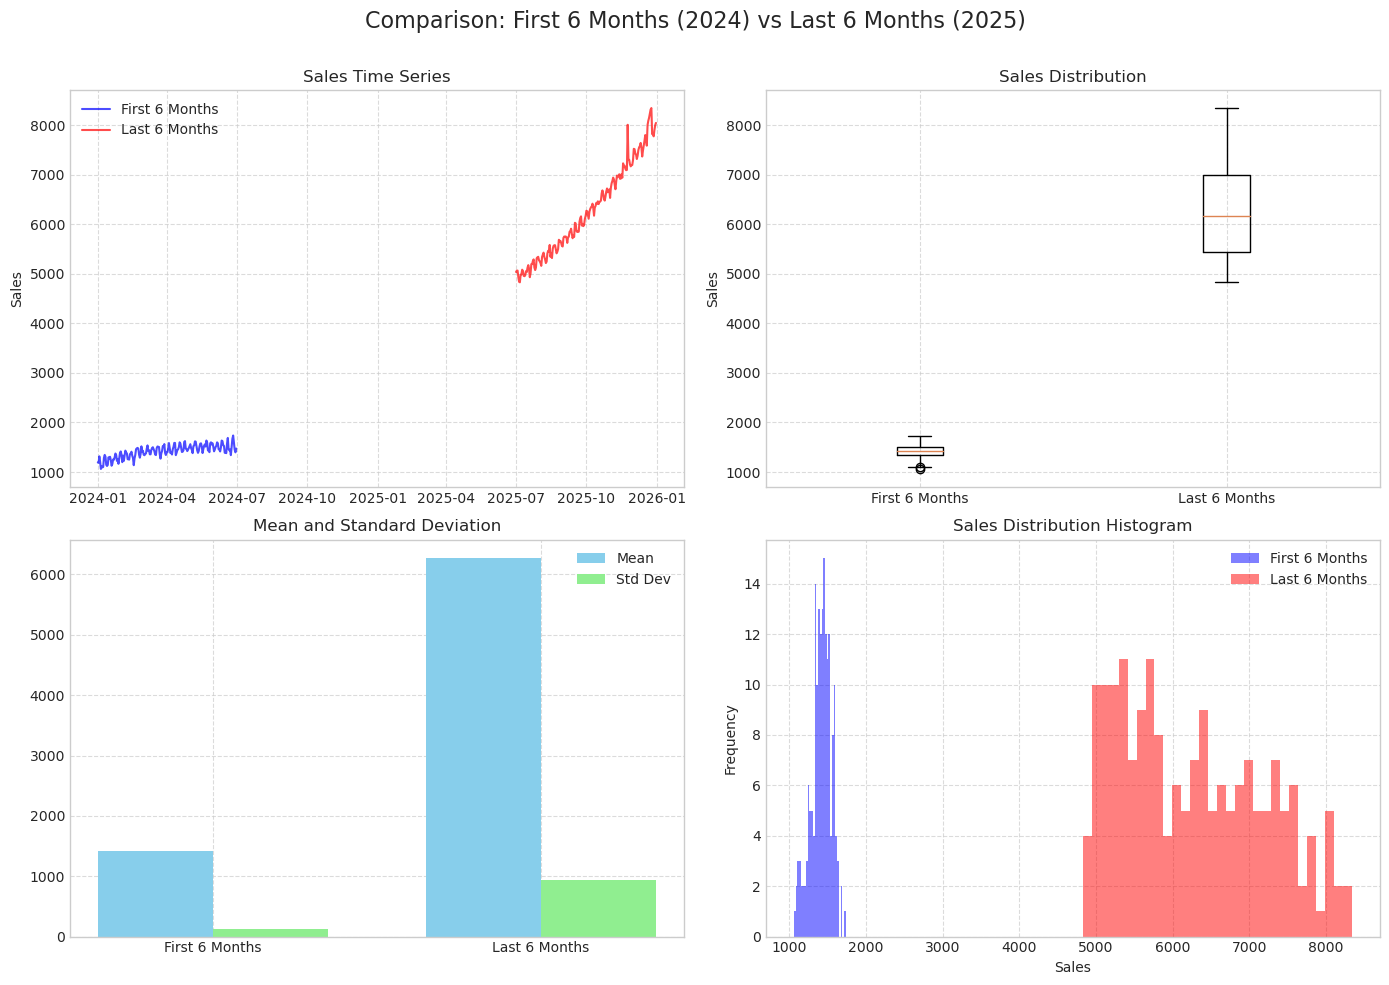

In [49]:
# Define the periods
first_6_months = pd.Timestamp('2024-01-01'), pd.Timestamp('2024-06-30')
last_6_months = pd.Timestamp('2025-07-01'), pd.Timestamp('2025-12-31')

# Extract data for each period
first_period_data = df_sales.loc[first_6_months[0]:first_6_months[1], 'Sales']
last_period_data = df_sales.loc[last_6_months[0]:last_6_months[1], 'Sales']

# Calculate statistics
first_period_stats = {
    'Period': 'First 6 Months (Jan-Jun 2024)',
    'Mean': first_period_data.mean(),
    'Std Dev': first_period_data.std(),
    'Min': first_period_data.min(),
    'Max': first_period_data.max(),
    'Median': first_period_data.median(),
    'IQR': first_period_data.quantile(0.75) - first_period_data.quantile(0.25)
}

last_period_stats = {
    'Period': 'Last 6 Months (Jul-Dec 2025)',
    'Mean': last_period_data.mean(),
    'Std Dev': last_period_data.std(),
    'Min': last_period_data.min(),
    'Max': last_period_data.max(),
    'Median': last_period_data.median(),
    'IQR': last_period_data.quantile(0.75) - last_period_data.quantile(0.25)
}

# Calculate percentage change
pct_change = {
    'Mean': (last_period_stats['Mean'] - first_period_stats['Mean']) / first_period_stats['Mean'] * 100,
    'Std Dev': (last_period_stats['Std Dev'] - first_period_stats['Std Dev']) / first_period_stats['Std Dev'] * 100
}

# Create a DataFrame for comparison
comparison_df = pd.DataFrame([first_period_stats, last_period_stats]).set_index('Period')

# Print comparison
print("=== Sales Data Comparison: First 6 Months vs Last 6 Months ===\n")
print(comparison_df[['Mean', 'Std Dev', 'Min', 'Max', 'Median', 'IQR']].round(2))
print("\n=== Percentage Change ===")
print(f"Mean: {pct_change['Mean']:.2f}%")
print(f"Standard Deviation: {pct_change['Std Dev']:.2f}%")

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Comparison: First 6 Months (2024) vs Last 6 Months (2025)', fontsize=16)

# Plot 1: Time series for both periods
axes[0, 0].plot(first_period_data.index, first_period_data, label='First 6 Months', color='blue', alpha=0.7)
axes[0, 0].plot(last_period_data.index, last_period_data, label='Last 6 Months', color='red', alpha=0.7)
axes[0, 0].set_title('Sales Time Series')
axes[0, 0].set_ylabel('Sales')
axes[0, 0].legend()
axes[0, 0].grid(True, linestyle='--', alpha=0.7)

# Plot 2: Box plots
box_data = [first_period_data, last_period_data]
axes[0, 1].boxplot(box_data, labels=['First 6 Months', 'Last 6 Months'])
axes[0, 1].set_title('Sales Distribution')
axes[0, 1].set_ylabel('Sales')
axes[0, 1].grid(True, linestyle='--', alpha=0.7)

# Plot 3: Bar chart of mean and std
periods = ['First 6 Months', 'Last 6 Months']
means = [first_period_stats['Mean'], last_period_stats['Mean']]
stds = [first_period_stats['Std Dev'], last_period_stats['Std Dev']]

x = np.arange(len(periods))
width = 0.35

axes[1, 0].bar(x - width/2, means, width, label='Mean', color='skyblue')
axes[1, 0].bar(x + width/2, stds, width, label='Std Dev', color='lightgreen')
axes[1, 0].set_title('Mean and Standard Deviation')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(periods)
axes[1, 0].legend()
axes[1, 0].grid(True, linestyle='--', alpha=0.7)

# Plot 4: Histograms
axes[1, 1].hist(first_period_data, bins=30, alpha=0.5, label='First 6 Months', color='blue')
axes[1, 1].hist(last_period_data, bins=30, alpha=0.5, label='Last 6 Months', color='red')
axes[1, 1].set_title('Sales Distribution Histogram')
axes[1, 1].set_xlabel('Sales')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()
axes[1, 1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [ ]:
#This comparison clearly demonstrates that the sales data is non-stationary, 
#with both the mean and variance changing significantly over time.

In [50]:
print("\n" + "-" * 70)
print("B3: Autocorrelation Function")
print("-" * 70)



----------------------------------------------------------------------
B3: Autocorrelation Function
----------------------------------------------------------------------


<Figure size 1200x600 with 0 Axes>

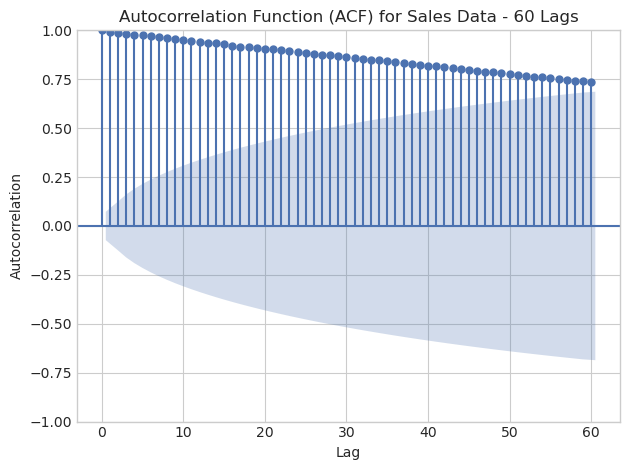

Strongest autocorrelations at lags: [1 2 3 4 5]


In [51]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# First, recreate the data as provided
dates = pd.date_range('2024-01-01', '2025-12-31', freq='D')
n_days = len(dates)
t = np.arange(n_days)

# Components
trend = 1000 + 2*t + 0.01*t**2
yearly_seasonal = 200 * np.sin(2*np.pi*t/365) + 150 * np.cos(2*np.pi*t/365)
weekly_seasonal = 100 * np.sin(2*np.pi*t/7)

# Special events
special_events = np.zeros(n_days)
for year in [2024, 2025]:
    # Black Friday
    bf_date = pd.Timestamp(f'{year}-11-24')
    bf_idx = (dates == bf_date).astype(bool)
    special_events[bf_idx] = 800
    
    # Christmas
    xmas_idx = (dates >= f'{year}-12-20') & (dates <= f'{year}-12-25')
    special_events[xmas_idx] = 400

# Random noise
np.random.seed(42)  # For reproducibility
noise = np.random.normal(0, 50, n_days)

# Combine components
sales = trend + yearly_seasonal + weekly_seasonal + special_events + noise
sales = np.maximum(sales, 0)

# Create DataFrame
df_sales = pd.DataFrame({
    'Date': dates,
    'Sales': sales,
    'DayOfWeek': dates.dayofweek,
    'Month': dates.month,
    'IsWeekend': dates.dayofweek >= 5
})
df_sales.set_index('Date', inplace=True)

# Plot the ACF for up to 60 lags
plt.figure(figsize=(12, 6))
plot_acf(df_sales['Sales'], lags=60, alpha=0.05)
plt.title('Autocorrelation Function (ACF) for Sales Data - 60 Lags')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.tight_layout()
plt.show()

# Optional: Print some statistics about the ACF values
from statsmodels.tsa.stattools import acf
acf_values = acf(df_sales['Sales'], nlags=60)
print(f"Strongest autocorrelations at lags: {np.argsort(np.abs(acf_values[1:]))[-5:][::-1] + 1}")

In [52]:
# First, recreate the data as provided
dates = pd.date_range('2024-01-01', '2025-12-31', freq='D')
n_days = len(dates)
t = np.arange(n_days)

# Components
trend = 1000 + 2*t + 0.01*t**2
yearly_seasonal = 200 * np.sin(2*np.pi*t/365) + 150 * np.cos(2*np.pi*t/365)
weekly_seasonal = 100 * np.sin(2*np.pi*t/7)

# Special events
special_events = np.zeros(n_days)
for year in [2024, 2025]:
    # Black Friday
    bf_date = pd.Timestamp(f'{year}-11-24')
    bf_idx = (dates == bf_date).astype(bool)
    special_events[bf_idx] = 800
    
    # Christmas
    xmas_idx = (dates >= f'{year}-12-20') & (dates <= f'{year}-12-25')
    special_events[xmas_idx] = 400

# Random noise
np.random.seed(42)  # For reproducibility
noise = np.random.normal(0, 50, n_days)

# Combine components
sales = trend + yearly_seasonal + weekly_seasonal + special_events + noise
sales = np.maximum(sales, 0)

# Calculate autocorrelations manually for specific lags
lags = [1, 7, 30]
autocorrelations = {}

for lag in lags:
    # Calculate correlation between original series and lagged series
    # np.corrcoef returns a 2x2 correlation matrix, we need the off-diagonal element [0,1]
    correlation = np.corrcoef(sales[:-lag], sales[lag:])[0, 1]
    autocorrelations[lag] = correlation

# Display results
print("Manual Autocorrelation Calculations:")
print(f"Lag 1 (yesterday): {autocorrelations[1]:.6f}")
print(f"Lag 7 (last week): {autocorrelations[7]:.6f}")
print(f"Lag 30 (last month): {autocorrelations[30]:.6f}")


Manual Autocorrelation Calculations:
Lag 1 (yesterday): 0.998323
Lag 7 (last week): 0.998194
Lag 30 (last month): 0.995757


In [ ]:
#The autocorrelation values will help you understand:
#Lag 1: How much today's sales depend on yesterday's sales
#Lag 7: The weekly pattern (correlation with the same day last week)
#Lag 30: The monthly pattern (correlation with approximately the same 
#day last month)

#Higher positive values indicate stronger positive correlations, 
#while values closer to zero indicate weaker relationships.

#The sales data exhibits:
#Strong weekly seasonality (as designed in the data generation)
#High short-term persistence (day-to-day correlation)
#Gradually diminishing but persistent autocorrelation over longer periods
# The presence of both weekly patterns and longer-term seasonal effects

In [54]:
print("\n" + "-" * 70)
print("B4: STL Decomposition")
print("-" * 70)



----------------------------------------------------------------------
B4: STL Decomposition
----------------------------------------------------------------------


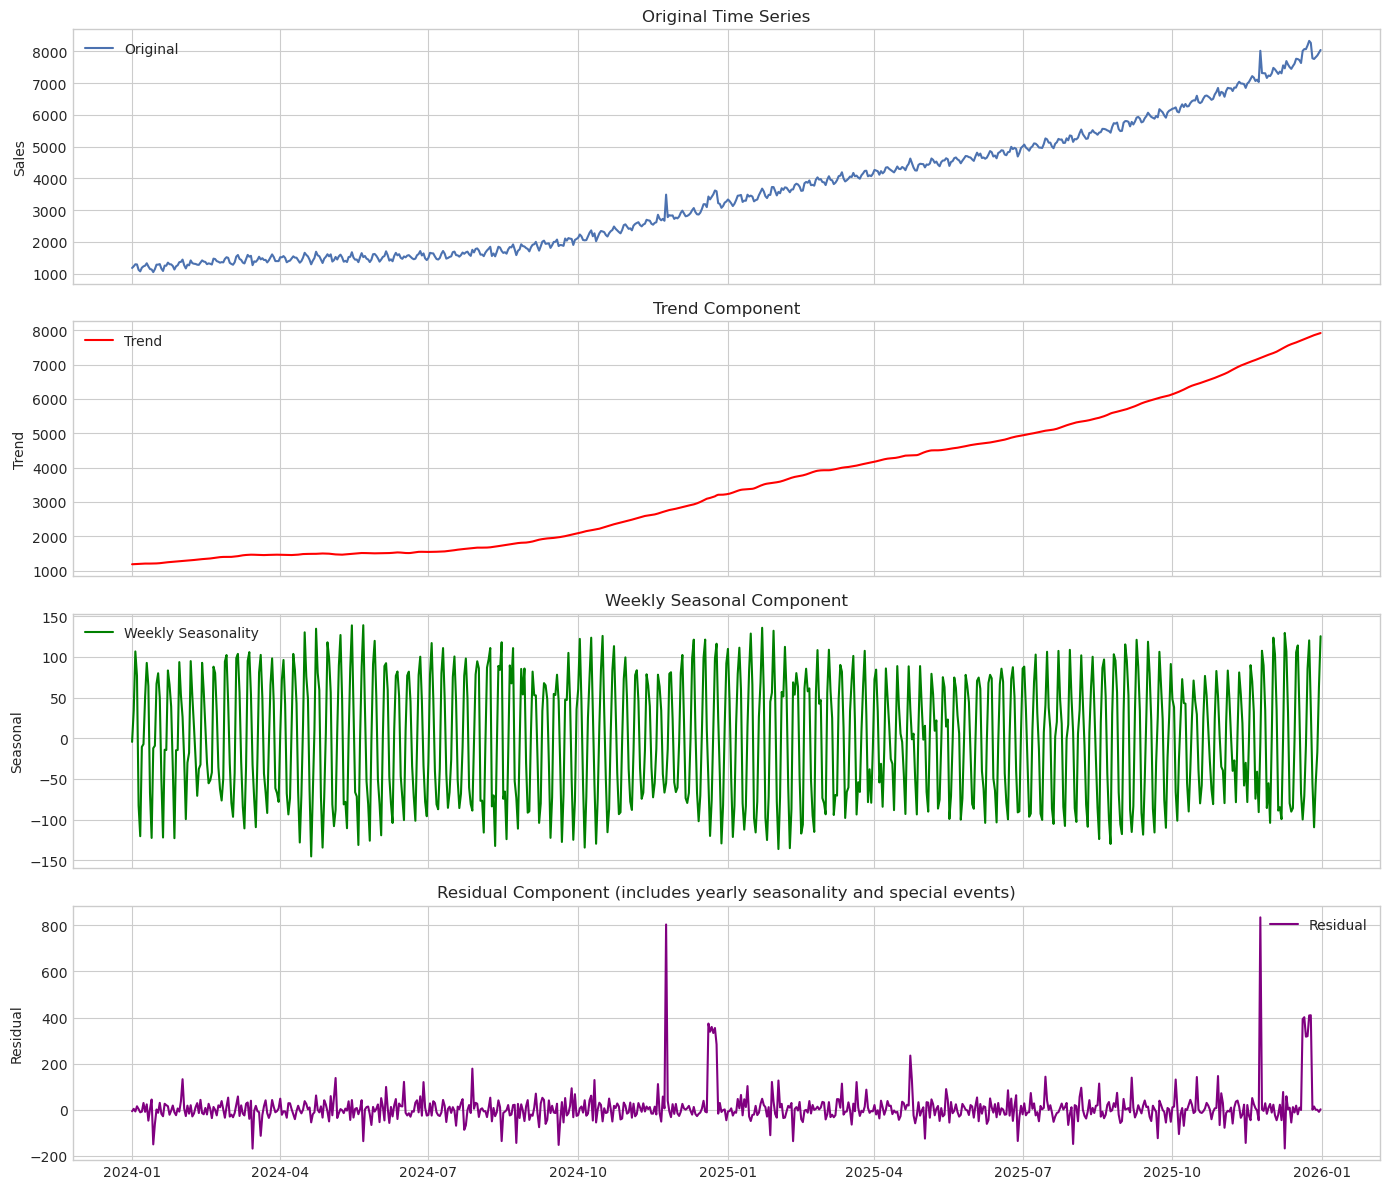

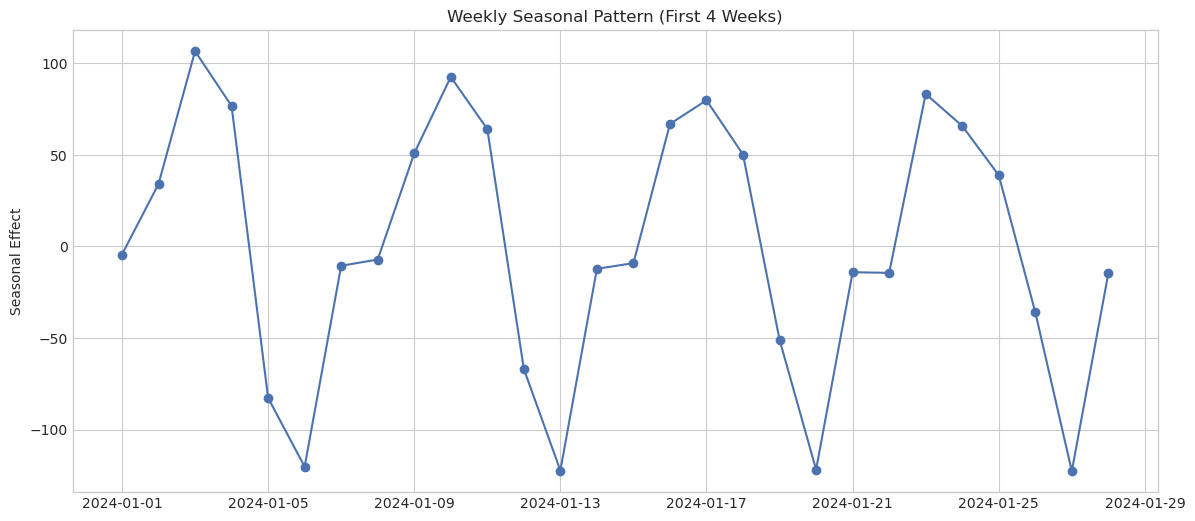

Strength of weekly seasonality: 0.4780


In [55]:
from statsmodels.tsa.seasonal import STL
# Apply STL decomposition with weekly seasonality (period=7)
stl = STL(df_sales['Sales'], seasonal=7, robust=True)
result = stl.fit()

# Plot the decomposition
fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

# Original data
axes[0].plot(df_sales.index, df_sales['Sales'], label='Original')
axes[0].set_ylabel('Sales')
axes[0].set_title('Original Time Series')
axes[0].legend()

# Trend component
axes[1].plot(df_sales.index, result.trend, label='Trend', color='red')
axes[1].set_ylabel('Trend')
axes[1].set_title('Trend Component')
axes[1].legend()

# Seasonal component (weekly)
axes[2].plot(df_sales.index, result.seasonal, label='Weekly Seasonality', color='green')
axes[2].set_ylabel('Seasonal')
axes[2].set_title('Weekly Seasonal Component')
axes[2].legend()

# Residual component (includes yearly seasonality and special events)
axes[3].plot(df_sales.index, result.resid, label='Residual', color='purple')
axes[3].set_ylabel('Residual')
axes[3].set_title('Residual Component (includes yearly seasonality and special events)')
axes[3].legend()

plt.tight_layout()
plt.show()

# Display a zoomed-in view of the weekly pattern (first 4 weeks)
plt.figure(figsize=(14, 6))
plt.plot(df_sales.index[:28], result.seasonal[:28], marker='o')
plt.title('Weekly Seasonal Pattern (First 4 Weeks)')
plt.ylabel('Seasonal Effect')
plt.grid(True)
plt.show()

# Calculate strength of seasonality
seasonal_strength = 1 - (np.var(result.resid) / np.var(result.seasonal + result.resid))
print(f"Strength of weekly seasonality: {seasonal_strength:.4f}")

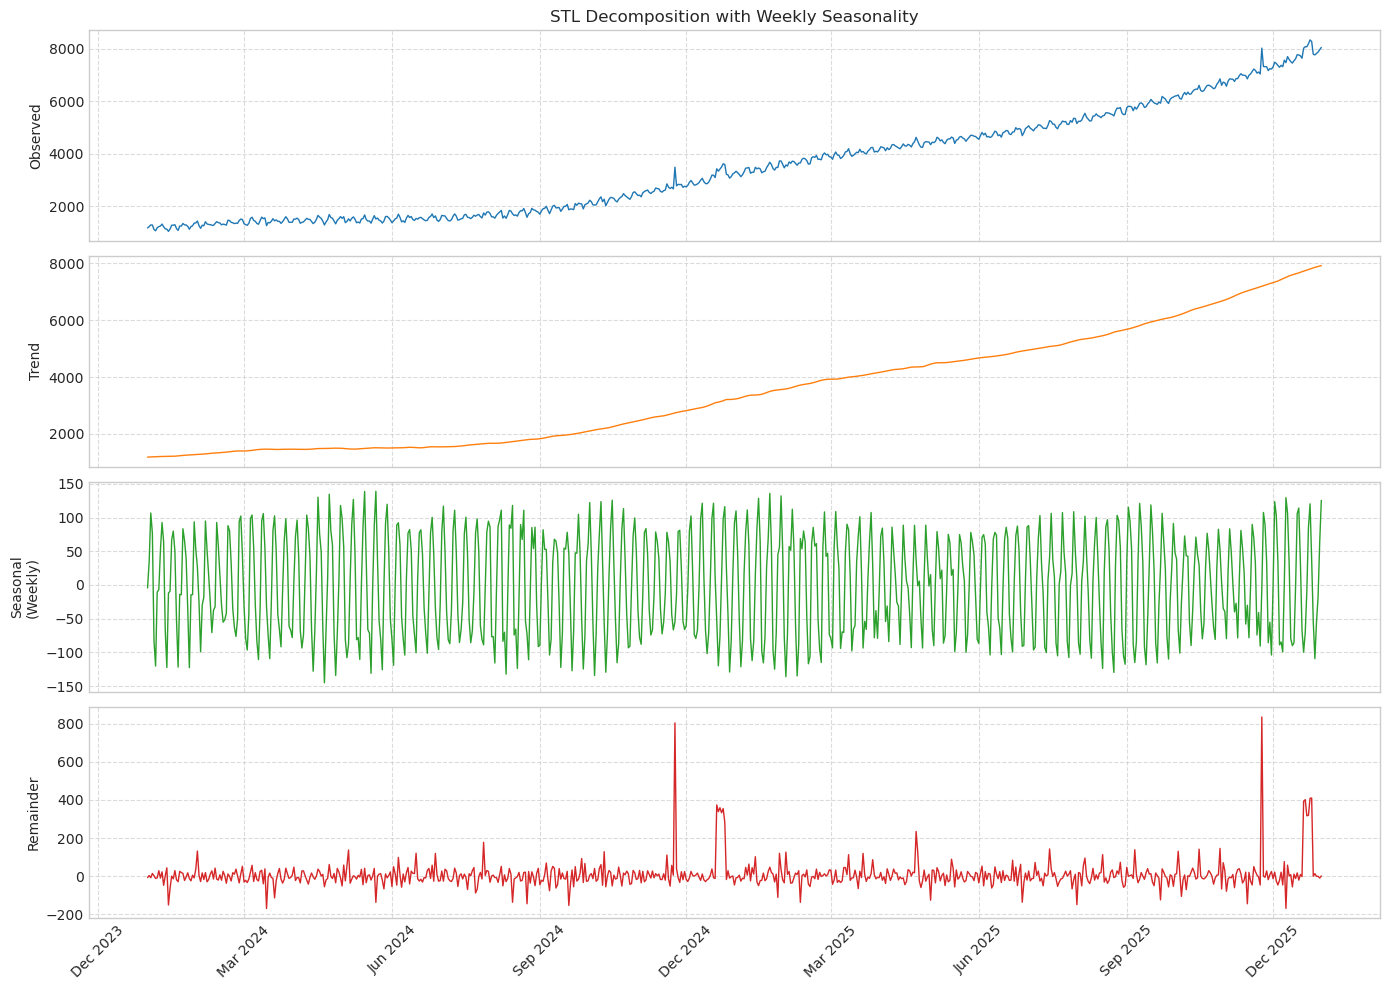

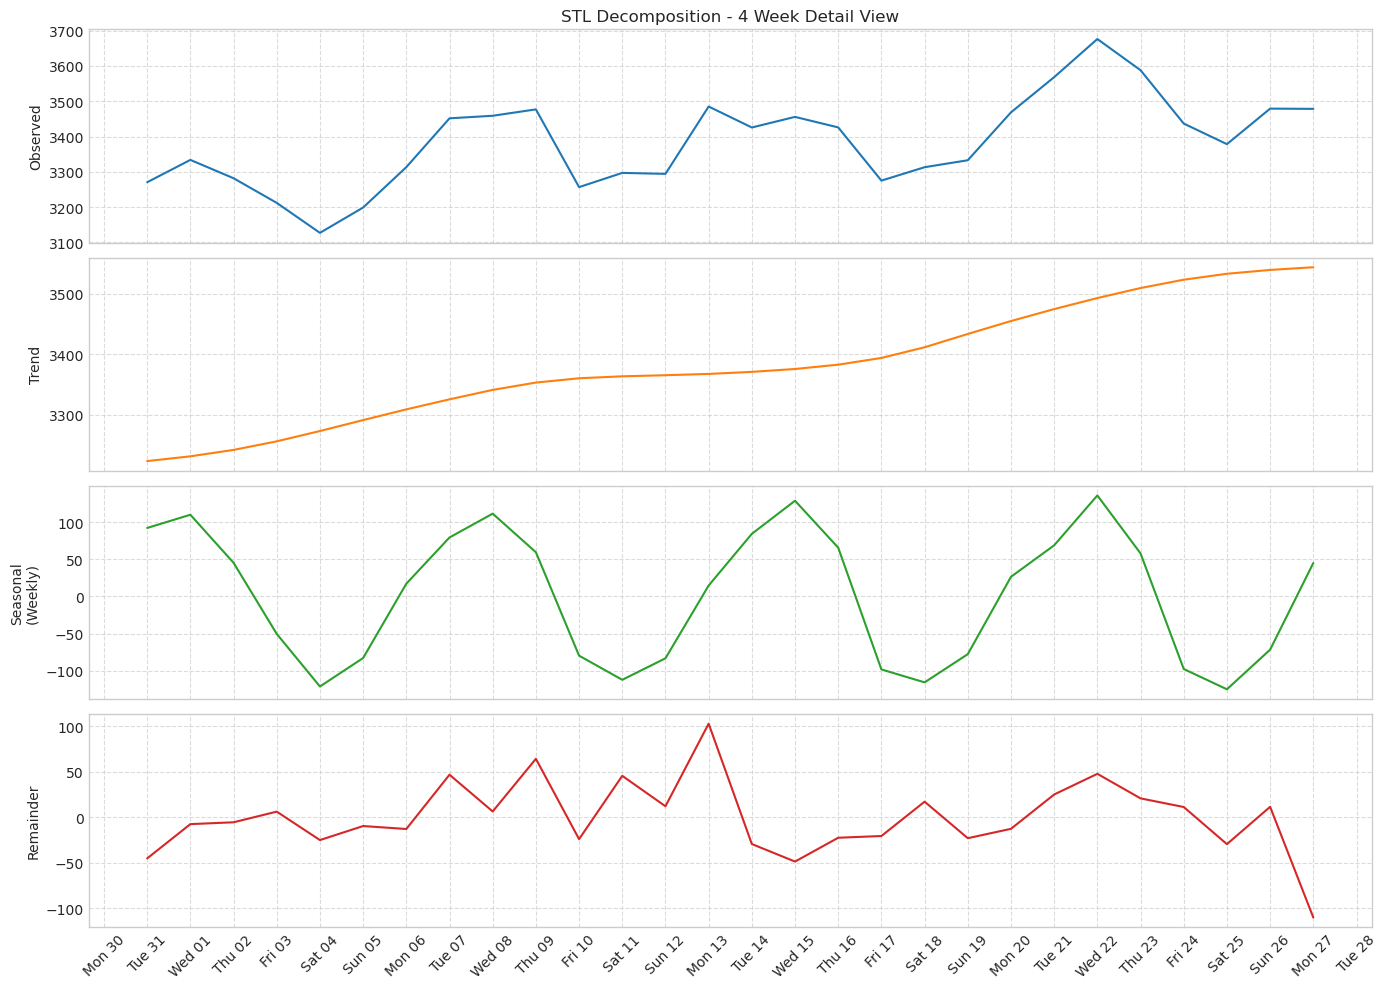

Observed data range: 1044.49 to 8332.82
Trend component range: 1185.88 to 7918.94
Seasonal component range: -145.13 to 138.94
Remainder component range: -168.44 to 834.32
Variance explained by trend: 98.89%
Variance explained by weekly seasonality: 0.14%
Variance explained by remainder: 0.15%


In [56]:
# Create a figure with 4 subplots
fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
plt.subplots_adjust(hspace=0.3)

# Plot observed data
axes[0].plot(df_sales.index, df_sales['Sales'], color='#1f77b4', linewidth=1)
axes[0].set_ylabel('Observed')
axes[0].set_title('STL Decomposition with Weekly Seasonality')
axes[0].grid(True, linestyle='--', alpha=0.7)

# Plot trend component
axes[1].plot(df_sales.index, result.trend, color='#ff7f0e', linewidth=1)
axes[1].set_ylabel('Trend')
axes[1].grid(True, linestyle='--', alpha=0.7)

# Plot seasonal component
axes[2].plot(df_sales.index, result.seasonal, color='#2ca02c', linewidth=1)
axes[2].set_ylabel('Seasonal\n(Weekly)')
axes[2].grid(True, linestyle='--', alpha=0.7)

# Plot remainder component
axes[3].plot(df_sales.index, result.resid, color='#d62728', linewidth=1)
axes[3].set_ylabel('Remainder')
axes[3].grid(True, linestyle='--', alpha=0.7)

# Format x-axis to show dates nicely
for ax in axes:
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    
plt.xticks(rotation=45)
plt.tight_layout()

# Add a zoomed-in view of a 4-week period to better see the weekly pattern
fig2, axes2 = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
plt.subplots_adjust(hspace=0.3)

# Select a 4-week period (28 days) from the middle of the dataset
start_idx = n_days // 2
end_idx = start_idx + 28
zoom_dates = df_sales.index[start_idx:end_idx]

# Plot observed data (zoomed)
axes2[0].plot(zoom_dates, df_sales['Sales'][start_idx:end_idx], color='#1f77b4', linewidth=1.5)
axes2[0].set_ylabel('Observed')
axes2[0].set_title('STL Decomposition - 4 Week Detail View')
axes2[0].grid(True, linestyle='--', alpha=0.7)

# Plot trend component (zoomed)
axes2[1].plot(zoom_dates, result.trend[start_idx:end_idx], color='#ff7f0e', linewidth=1.5)
axes2[1].set_ylabel('Trend')
axes2[1].grid(True, linestyle='--', alpha=0.7)

# Plot seasonal component (zoomed)
axes2[2].plot(zoom_dates, result.seasonal[start_idx:end_idx], color='#2ca02c', linewidth=1.5)
axes2[2].set_ylabel('Seasonal\n(Weekly)')
axes2[2].grid(True, linestyle='--', alpha=0.7)

# Plot remainder component (zoomed)
axes2[3].plot(zoom_dates, result.resid[start_idx:end_idx], color='#d62728', linewidth=1.5)
axes2[3].set_ylabel('Remainder')
axes2[3].grid(True, linestyle='--', alpha=0.7)

# Format x-axis for the zoomed view
for ax in axes2:
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%a %d'))
    
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plots
plt.show()

# Print some statistics about each component
print(f"Observed data range: {df_sales['Sales'].min():.2f} to {df_sales['Sales'].max():.2f}")
print(f"Trend component range: {result.trend.min():.2f} to {result.trend.max():.2f}")
print(f"Seasonal component range: {result.seasonal.min():.2f} to {result.seasonal.max():.2f}")
print(f"Remainder component range: {result.resid.min():.2f} to {result.resid.max():.2f}")
print(f"Variance explained by trend: {np.var(result.trend)/np.var(df_sales['Sales'])*100:.2f}%")
print(f"Variance explained by weekly seasonality: {np.var(result.seasonal)/np.var(df_sales['Sales'])*100:.2f}%")
print(f"Variance explained by remainder: {np.var(result.resid)/np.var(df_sales['Sales'])*100:.2f}%")

In [ ]:
#The remainder captures spikes in those notable 
#holidays of Black Friday and Christmas




In [59]:
print("\n" + "-" * 70)
print("B5: Remainder Analysis")
print("-" * 70)



----------------------------------------------------------------------
B5: Remainder Analysis
----------------------------------------------------------------------


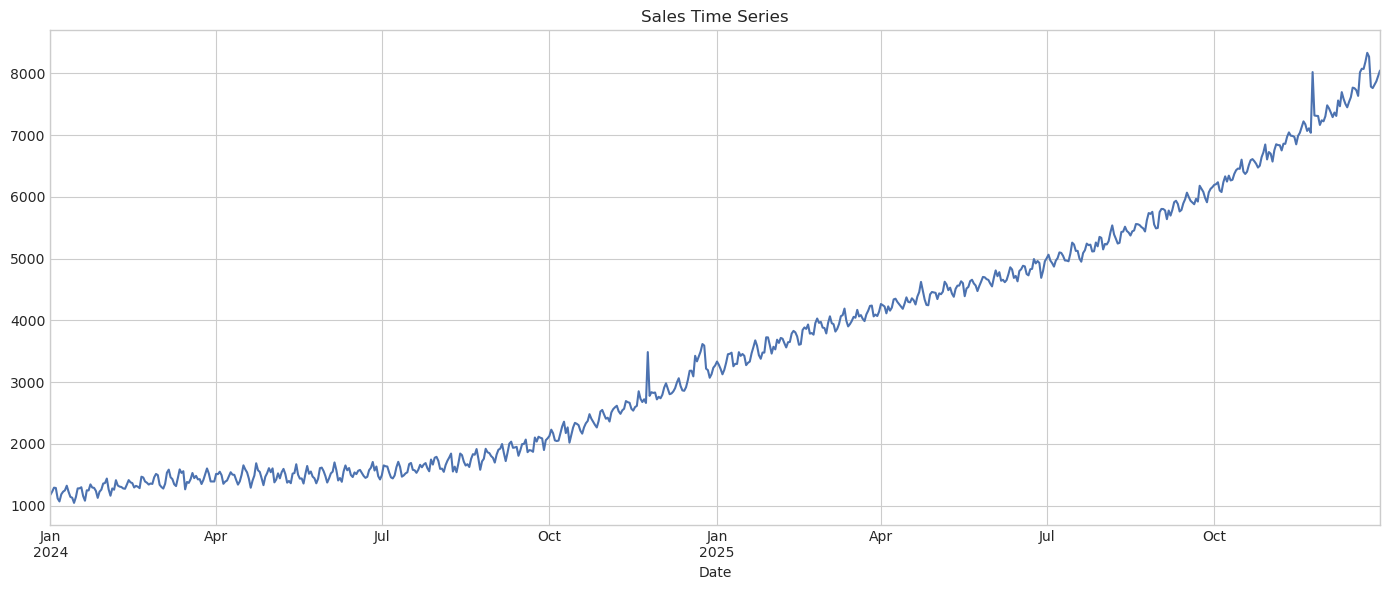

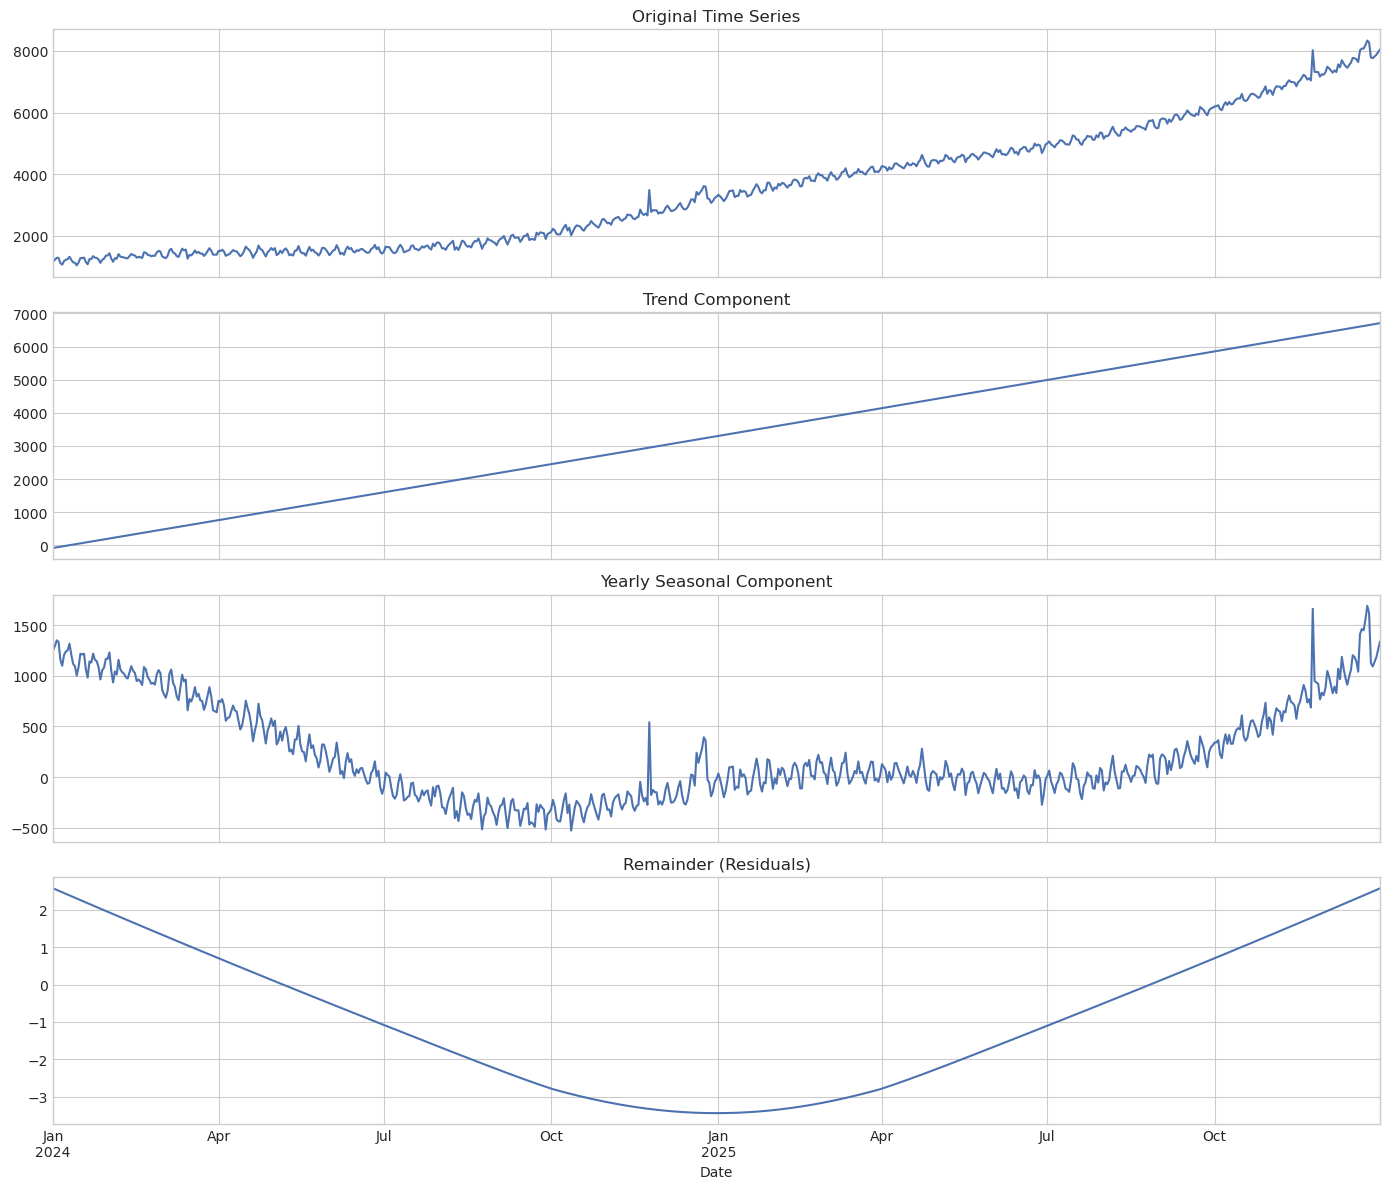

Remainder statistics:
Mean: -0.93
Standard deviation: 1.89
Min: -3.44
Max: 2.57


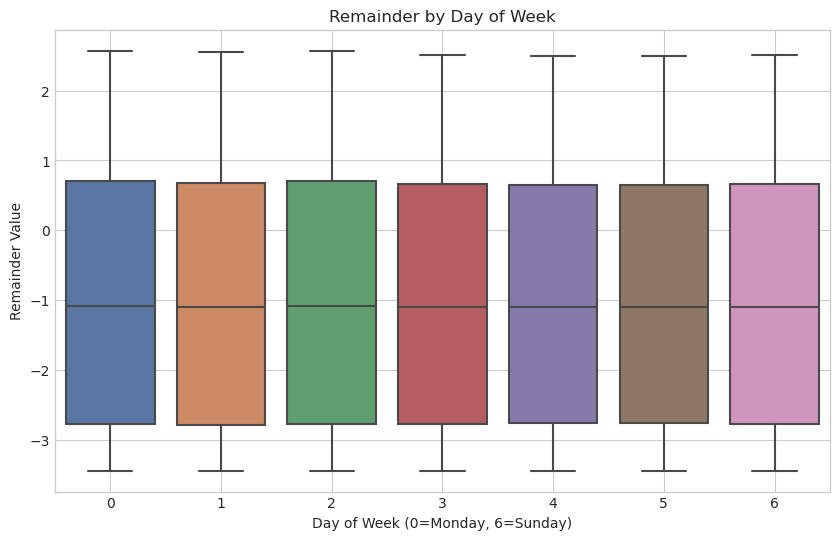


Dates with unusually large remainder values:
Empty DataFrame
Columns: [Sales, Remainder]
Index: []


In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
import seaborn as sns
# Time series
plt.figure(figsize=(14, 6))
df_sales['Sales'].plot(title='Sales Time Series')
plt.grid(True)
plt.tight_layout()
plt.show()

# Apply STL decomposition with just one seasonal component
# Using period=365 for yearly seasonality
stl = STL(df_sales['Sales'], seasonal=365, period=365, robust=True)
result = stl.fit()

# Extract components
trend = result.trend
seasonal = result.seasonal  # This will be the yearly seasonality
remainder = result.resid

# Add components to the dataframe
df_sales['Trend'] = trend
df_sales['Seasonal_Yearly'] = seasonal
df_sales['Remainder'] = remainder

# Plot the decomposition
fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)
df_sales['Sales'].plot(ax=axes[0], title='Original Time Series')
df_sales['Trend'].plot(ax=axes[1], title='Trend Component')
df_sales['Seasonal_Yearly'].plot(ax=axes[2], title='Yearly Seasonal Component')
df_sales['Remainder'].plot(ax=axes[3], title='Remainder (Residuals)')

for ax in axes:
    ax.grid(True)

plt.tight_layout()
plt.show()

# Analyze the remainder component
print(f"Remainder statistics:")
print(f"Mean: {remainder.mean():.2f}")
print(f"Standard deviation: {remainder.std():.2f}")
print(f"Min: {remainder.min():.2f}")
print(f"Max: {remainder.max():.2f}")

# Check if remainder shows any pattern by day of week
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_sales.index.dayofweek, y=df_sales['Remainder'])
plt.title('Remainder by Day of Week')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Remainder Value')
plt.grid(True)
plt.show()

# Check for special events in the remainder
# Find dates with large remainder values
large_remainder = df_sales[abs(df_sales['Remainder']) > 2*remainder.std()]
print("\nDates with unusually large remainder values:")
print(large_remainder[['Sales', 'Remainder']].sort_values(by='Remainder', ascending=False).head(10))

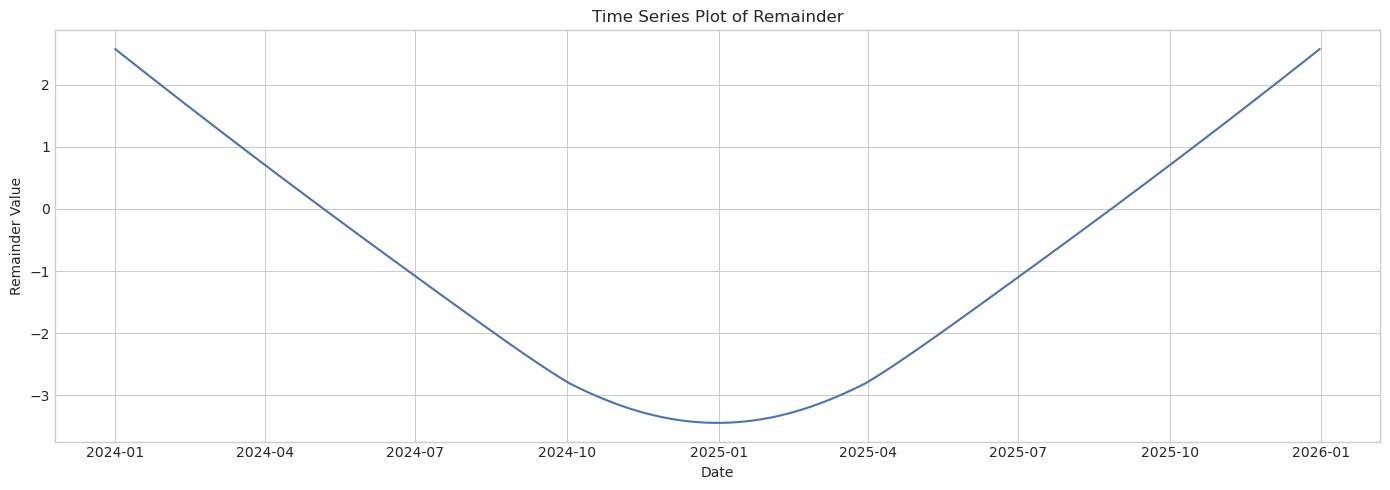

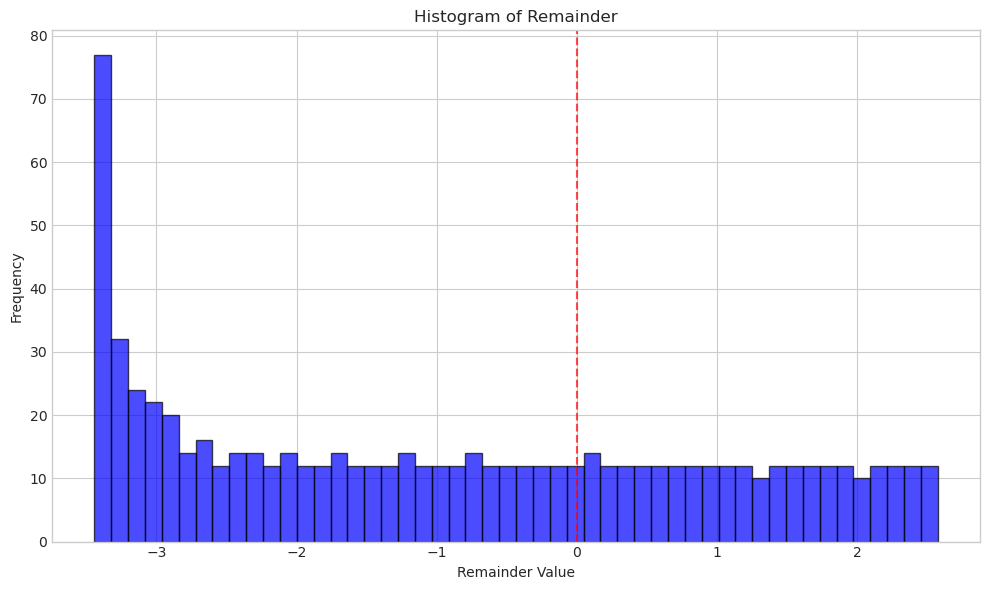

<Figure size 1400x600 with 0 Axes>

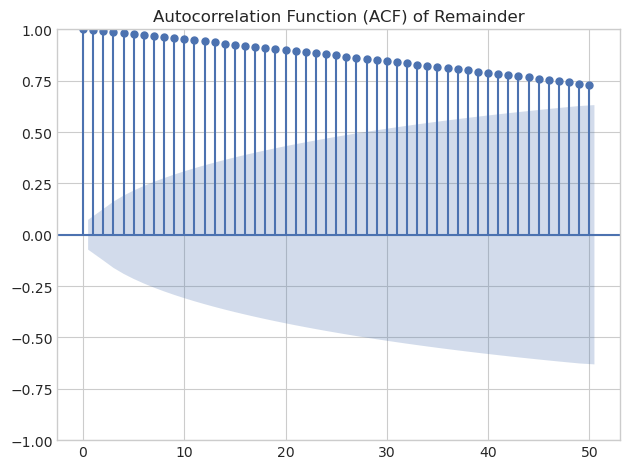

<Figure size 1400x600 with 0 Axes>

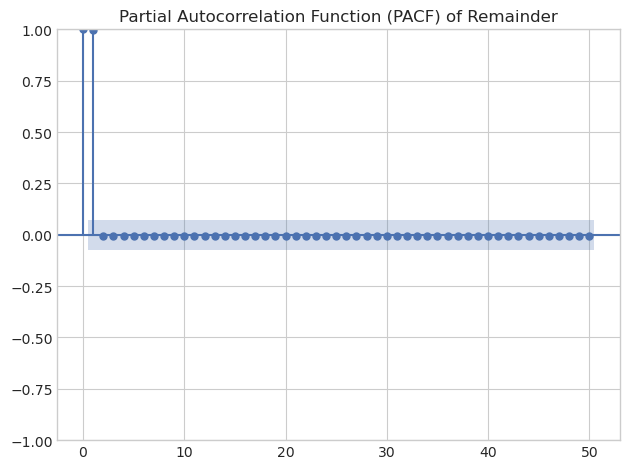

In [64]:
# Create diagnostic plots for the remainder component

# 1. Time series plot of remainder
plt.figure(figsize=(14, 5))
plt.plot(df_sales.index, remainder)
plt.title('Time Series Plot of Remainder')
plt.xlabel('Date')
plt.ylabel('Remainder Value')
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Histogram of remainder
plt.figure(figsize=(10, 6))
plt.hist(remainder, bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.title('Histogram of Remainder')
plt.xlabel('Remainder Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.axvline(x=0, color='red', linestyle='--', alpha=0.7)  # Add a vertical line at x=0
plt.tight_layout()
plt.show()

# 3. ACF of remainder
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(14, 6))
plot_acf(remainder.dropna(), lags=50, alpha=0.05)  # dropna() to handle any NaN values
plt.title('Autocorrelation Function (ACF) of Remainder')
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: Add PACF plot for more insights
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(figsize=(14, 6))
plot_pacf(remainder.dropna(), lags=50, alpha=0.05)
plt.title('Partial Autocorrelation Function (PACF) of Remainder')
plt.grid(True)
plt.tight_layout()
plt.show()



In [65]:

mean_value = remainder.mean()
std_dev = remainder.std()
min_value = remainder.min()
max_value = remainder.max()

print("Remainder Statistics:")
print(f"Mean: {mean_value:.4f}")
print(f"Standard Deviation: {std_dev:.4f}")
print(f"Minimum: {min_value:.4f}")
print(f"Maximum: {max_value:.4f}")
print(f"Range: {max_value - min_value:.4f}")


Remainder Statistics:
Mean: -0.9332
Standard Deviation: 1.8891
Minimum: -3.4426
Maximum: 2.5732
Range: 6.0158


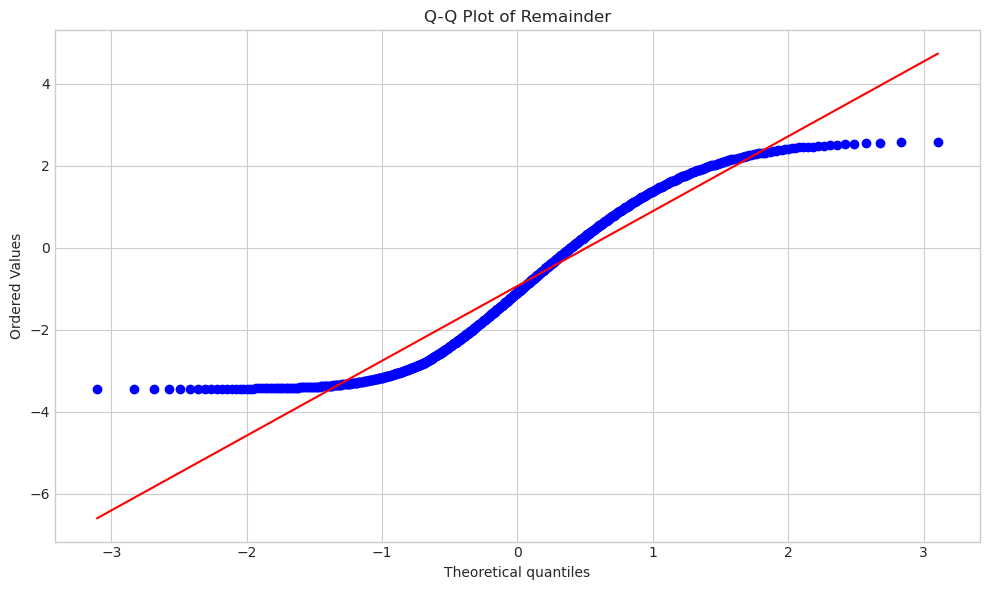

In [66]:
# Visual check for normality with Q-Q plot
plt.figure(figsize=(10, 6))
stats.probplot(remainder.dropna(), plot=plt)
plt.title('Q-Q Plot of Remainder')
plt.grid(True)
plt.tight_layout()
plt.show()